In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
    
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler
from ml.utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores, find_all
import shap
shap.initjs()

In [2]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [3]:
df = pd.read_csv("final_autof.csv")
df.drop([
    'MODE(consumptions.MS_METER_NBR)',
    'MODE(representations.SUPPLIER)',
    'MODE(representations.SUPPLIER_TO)',
], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


COUNT(consumptions)  MAX(consumptions.CSS_MS_HS_USE)  \
0                  4.0                            135.0   
1                 10.0                            127.0   
2                 12.0                           6068.0   
3                  6.0                           1061.0   
4                 24.0                           1247.0   

   MEAN(consumptions.CSS_MS_HS_USE)  MIN(consumptions.CSS_MS_HS_USE)  \
0                         64.250000                             12.0   
1                         51.900000                              0.0   
2                       3924.166667                           2446.0   
3                        479.333333                              7.0   
4                        536.833333                              0.0   

   NUM_UNIQUE(consumptions.BS_RATE)  NUM_UNIQUE(consumptions.MS_METER_NBR)  \
0                               1.0                                    1.0   
1                               1.0                                    2.0   
2                               1.0                                    1.0   
3                               2.0                                    1.0   
4                               2.0                                    1.0   

   SKEW(consumptions.CSS_MS_HS_USE)  STD(consumptions.CSS_MS_HS_USE)  \
0                          0.758461                        54.389797   
1                          0.783315                        43.072162   
2                          0.574519                      1012.516472   
3                          0.020392                       409.340282   
4                          0.537625                       335.364392   

   SUM(consumptions.CSS_MS_HS_USE)  MODE(consumptions.DAY(MEASUREMENT_DATE))  \
0                            257.0                                       2.0   
1                            519.0                                       2.0   
2                          47090.0                                      28.0   
3                           2876.0                                       4.0   
4                          12884.0                                       4.0   

   ...  MODE(consumptions.BS_RATE)_40  MODE(consumptions.BS_RATE)_41  \
0  ...                              0                              0   
1  ...                              0                              0   
2  ...                              0                              0   
3  ...                              0                              0   
4  ...                              0                              0   

   MODE(consumptions.BS_RATE)_42  MODE(consumptions.BS_RATE)_43  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   MODE(consumptions.BS_RATE)_44  MODE(consumptions.BS_RATE)_52  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   MODE(consumptions.BS_RATE)_53  MODE(consumptions.BS_RATE)_54  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   MODE(consumptions.BS_RATE)_55  MODE(consumptions.BS_RATE)_other  
0                              0                                 0  
1                              0                    

In [4]:
original_df = df.copy()

In [5]:
def train(clf, X, y, cols):
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    brier_scores, auc_roc_scores, pr_auc_scores = [], [], []
    lift_scores, demotion_scores, weighted_scores = [], [], []
    scaler = MinMaxScaler()
    print("Classifier: CATBOOST")
    assert len(X) == len(y)
    print("Number of samples:", len(X))
    print("Data bins", np.bincount(y))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        print("Shape", X_train.shape)
        
        
        print("bins", np.bincount(y_train))
        print("bins", np.bincount(y_test))

        clf.fit(X_train, y_train, verbose=False)

        y_pred = clf.predict(X_test)

        acc, precision, recall, f1 = get_classification_metrics(y_test.values, y_pred)

        y_scores = clf.predict_proba(X_test)
        idx = np.argmax(y_scores, axis=1)
        y_scores = np.where(idx == 0, 1 - y_scores[:, 0], y_scores[:, 1])


        brier, roc_auc, pr_auc = get_probability_measures(y_test.values, y_scores)

        num_ones = np.sum(y_test == 1)


        s1 = int(0.1 * num_ones)
        s2 = int(0.2 * num_ones)
        s3 = int(0.3 * num_ones)
        s4 = int(0.4 * num_ones)
        s5 = int(0.5 * num_ones)
        s6 = int(0.6 * num_ones)
        s7 = int(0.7 * num_ones)
        s8 = int(0.8 * num_ones)
        s9 = int(0.9 * num_ones)
        s10 = int(1 * num_ones)

        lift1, demotion1, weighted_score1 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s1)
        lift2, demotion2, weighted_score2 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s2)
        lift3, demotion3, weighted_score3 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s3)
        lift4, demotion4, weighted_score4 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s4)
        lift5, demotion5, weighted_score5 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s5)
        lift6, demotion6, weighted_score6 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s6)
        lift7, demotion7, weighted_score7 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s7)
        lift8, demotion8, weighted_score8 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s8)
        lift9, demotion9, weighted_score9 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s9)
        lift10, demotion10, weighted_score10 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s10)

        acc_scores.append(acc)
        prec_scores.append(precision)
        rec_scores.append(recall)
        f1_scores.append(f1)

        brier_scores.append(brier)
        auc_roc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)

        lift_scores.append(lift4)
        demotion_scores.append(demotion4)
        weighted_scores.append(weighted_score4)

        print(f"0.1 -- Lift: {lift1:.4f}, Demotion: {demotion1:.4f}, Weighted: {weighted_score1:.4f}")
        print(f"0.2 -- Lift: {lift2:.4f}, Demotion: {demotion2:.4f}, Weighted: {weighted_score2:.4f}")
        print(f"0.3 -- Lift: {lift3:.4f}, Demotion: {demotion3:.4f}, Weighted: {weighted_score3:.4f}")
        print(f"0.4 -- Lift: {lift4:.4f}, Demotion: {demotion4:.4f}, Weighted: {weighted_score4:.4f}")
        print(f"0.5 -- Lift: {lift5:.4f}, Demotion: {demotion5:.4f}, Weighted: {weighted_score5:.4f}")
        print(f"0.6 -- Lift: {lift6:.4f}, Demotion: {demotion6:.4f}, Weighted: {weighted_score6:.4f}")
        print(f"0.7 -- Lift: {lift7:.4f}, Demotion: {demotion7:.4f}, Weighted: {weighted_score7:.4f}")
        print(f"0.8 -- Lift: {lift8:.4f}, Demotion: {demotion8:.4f}, Weighted: {weighted_score8:.4f}")
        print(f"0.9 -- Lift: {lift9:.4f}, Demotion: {demotion9:.4f}, Weighted: {weighted_score9:.4f}")
        print(f"1 -- Lift: {lift10:.4f}, Demotion: {demotion10:.4f}, Weighted: {weighted_score10:.4f}")

        #find_all(y_test.values, y_scores,)
        
        print("Fold {} - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}"
                .format(len(acc_scores), acc_scores[-1], prec_scores[-1], rec_scores[-1], f1_scores[-1],
                        brier_scores[-1], auc_roc_scores[-1], pr_auc_scores[-1],
                        lift_scores[-1], demotion_scores[-1], weighted_scores[-1]))
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=len(cols), feature_names=cols, show=False)
        plt.tight_layout()
        plt.show()
        plt.close()
        
    
    print("Average - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}\n"
            .format(sum(acc_scores)/len(acc_scores), sum(prec_scores)/len(prec_scores),
                    sum(rec_scores)/len(rec_scores), sum(f1_scores)/len(f1_scores),
                    sum(brier_scores)/len(brier_scores), sum(auc_roc_scores)/len(auc_roc_scores), sum(pr_auc_scores)/len(pr_auc_scores),
                    sum(lift_scores)/len(lift_scores), sum(demotion_scores)/len(demotion_scores), sum(weighted_scores)/len(weighted_scores)))

In [6]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

700519
700519


In [7]:
encodings = pd.read_csv('autoencoder_classifier_loss_encoded.csv')

In [8]:
df.reset_index(drop=True, inplace=True)
encodings.reset_index(drop=True, inplace=True)
df = df.join(encodings)
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.head()

700519
700519


COUNT(consumptions)  MAX(consumptions.CSS_MS_HS_USE)  \
0                  4.0                            135.0   
1                 10.0                            127.0   
2                 12.0                           6068.0   
3                  6.0                           1061.0   
4                 24.0                           1247.0   

   MEAN(consumptions.CSS_MS_HS_USE)  MIN(consumptions.CSS_MS_HS_USE)  \
0                         64.250000                             12.0   
1                         51.900000                              0.0   
2                       3924.166667                           2446.0   
3                        479.333333                              7.0   
4                        536.833333                              0.0   

   NUM_UNIQUE(consumptions.BS_RATE)  NUM_UNIQUE(consumptions.MS_METER_NBR)  \
0                               1.0                                    1.0   
1                               1.0                                    2.0   
2                               1.0                                    1.0   
3                               2.0                                    1.0   
4                               2.0                                    1.0   

   SKEW(consumptions.CSS_MS_HS_USE)  STD(consumptions.CSS_MS_HS_USE)  \
0                          0.758461                        54.389797   
1                          0.783315                        43.072162   
2                          0.574519                      1012.516472   
3                          0.020392                       409.340282   
4                          0.537625                       335.364392   

   SUM(consumptions.CSS_MS_HS_USE)  MODE(consumptions.DAY(MEASUREMENT_DATE))  \
0                            257.0                                       2.0   
1                            519.0                                       2.0   
2                          47090.0                                      28.0   
3                           2876.0                                       4.0   
4                          12884.0                                       4.0   

   ...  t_hidden_23  t_hidden_24  t_hidden_25  t_hidden_26  t_hidden_27  \
0  ...     0.227373     2.361559     1.938654    -0.574741    -1.066690   
1  ...     0.844264     0.836465     1.691065     0.117468    -0.533461   
2  ...    -0.011472     2.336785     2.482246    -1.427288    -0.665344   
3  ...    -0.675597     0.869136     1.958137    -0.506930    -1.264389   
4  ...    -0.425382     0.602726     1.124325     0.165342    -0.799687   

   t_hidden_28  t_hidden_29  t_hidden_30  t_hidden_31  t_hidden_32  
0     0.023123    -0.041047     0.218051    -1.160616    -1.216362  
1    -0.163281     0.552240    -0.471347    -0.875878    -0.599580  
2    -0.566080    -1.438796     0.712387     0.779548    -0.954446  
3    -0.298342    -0.625637    -0.404670     0.399970    -0.899167  
4     0.135509    -0.275075     0.080667     0.015887     0.094562  

[5 rows x 121 columns]

In [9]:
def plot_dist(thefts, non_thefts, col):
    print("col:", col)
    print("--"*1)
    print("THEFTS:")
    print(f"min={thefts[col].min()}, max={thefts[col].max()}, mean={thefts[col].mean()}")
    print(f"mode={thefts[col].mode()[0]}, kurtosis={thefts[col].kurtosis()}, skew={thefts[col].skew()}")
    print("")
    print("NON-THEFTS:")
    print(f"min={non_thefts[col].min()}, max={non_thefts[col].max()}, mean={non_thefts[col].mean()}")
    print(f"mode={non_thefts[col].mode()[0]}, kurtosis={non_thefts[col].kurtosis()}, skew={non_thefts[col].skew()}")
    print("--"*1)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5),)
    
    sns.histplot(thefts[col], kde=True, ax=ax[0], label=f'Thefts', stat='density')
    sns.histplot(non_thefts[col], kde=True, ax=ax[1], label=f'NonThefts', stat='density')
    
    x_axis = np.linspace(thefts[col].min(), thefts[col].max(), 100)
    ax[0].plot(x_axis, norm.pdf(x_axis, thefts[col].mean(), thefts[col].std()), label='Normal Distribution', color='red')
    ax[1].plot(x_axis, norm.pdf(x_axis, non_thefts[col].mean(), non_thefts[col].std()), label='Normal Distribution', color='red')
    
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [10]:
scaler = MinMaxScaler()
X = df.drop(['target'], axis=1)
y = df['target'].values

scaler.fit(X)
X = scaler.transform(X)
cols = list(df.columns)
cols.remove("target")
tmp = pd.DataFrame(X, columns=cols)
tmp['target'] = y

thefts = tmp.loc[tmp.target==1]
non_thefts = tmp.loc[tmp.target==0]

In [11]:
columns_to_visualize = [
    "COUNT(consumptions)",
    "SKEW(consumptions.CSS_MS_HS_USE)",
    "number_of_zeros",
]

col: COUNT(consumptions)
--
THEFTS:
min=0.0, max=0.9741379310344828, mean=0.09891019374333453
mode=0.07758620689655173, kurtosis=28.826774542722873, skew=3.7307841762317864

NON-THEFTS:
min=0.0, max=1.0, mean=0.10296278108536822
mode=0.11206896551724137, kurtosis=19.403132719448454, skew=2.513561621910922
--


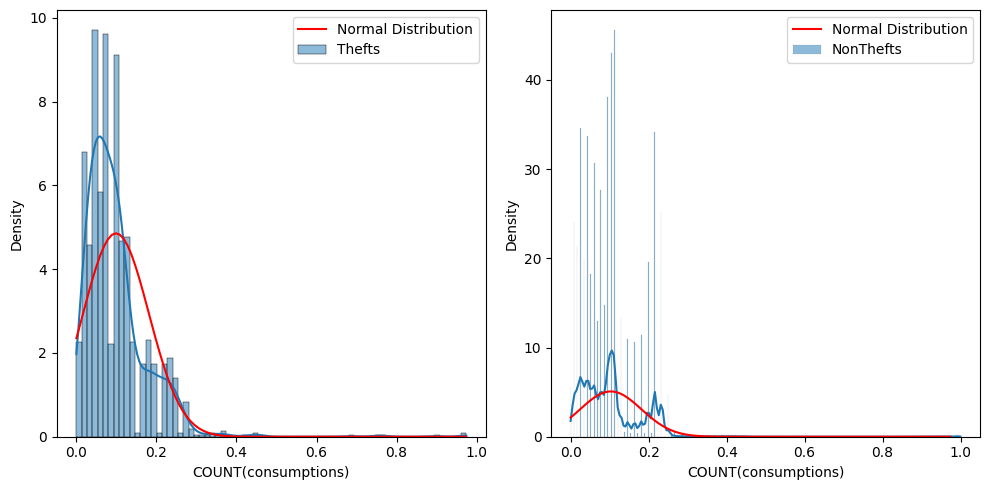

col: SKEW(consumptions.CSS_MS_HS_USE)
--
THEFTS:
min=0.08877458828390009, max=0.7976735648278732, mean=0.41116326141129744
mode=0.32076312647920374, kurtosis=0.37032635185212426, skew=0.23586778734049846

NON-THEFTS:
min=0.0, max=1.0, mean=0.3903769977560246
mode=0.32076312647920374, kurtosis=0.7409763333159729, skew=-0.10178199429743909
--


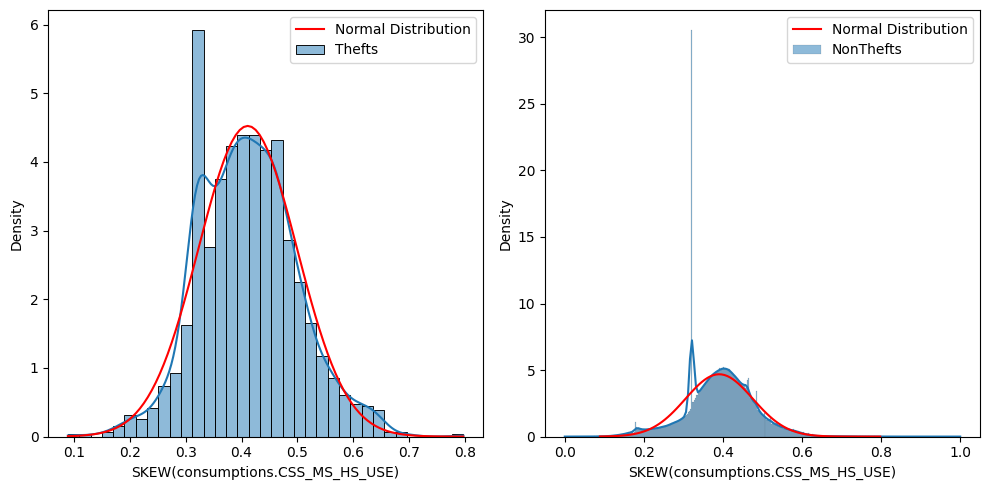

col: number_of_zeros
--
THEFTS:
min=0.0, max=0.2807017543859649, mean=0.02022291553626334
mode=0.0, kurtosis=9.792246057449908, skew=2.8664333317660997

NON-THEFTS:
min=0.0, max=1.0, mean=0.005383357831892222
mode=0.0, kurtosis=90.70695688257439, skew=7.358626422286925
--


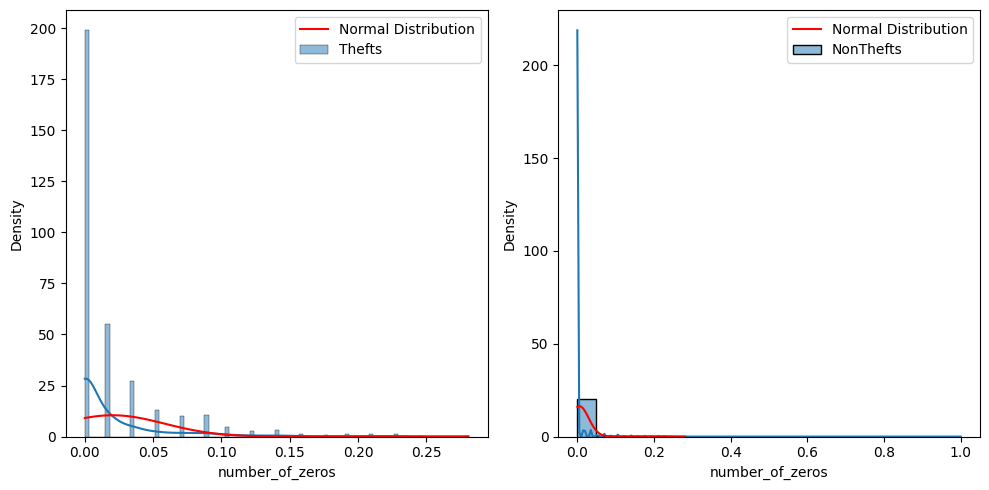

col: t_hidden_1
--
THEFTS:
min=0.5442326072901046, max=0.8391401592178119, mean=0.7505947329447707
mode=0.5442326072901046, kurtosis=1.7449880612979096, skew=-0.2523832473635885

NON-THEFTS:
min=0.0, max=1.0, mean=0.7703209466428427
mode=0.815607737413581, kurtosis=1.453737735957429, skew=0.21750506976558964
--


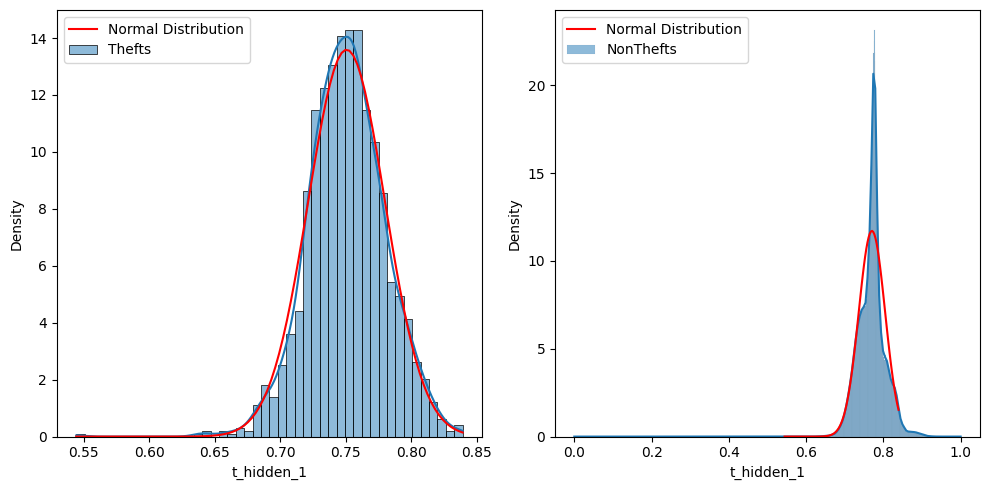

col: t_hidden_2
--
THEFTS:
min=0.12062880905590598, max=0.4670710096732904, mean=0.3000056545315577
mode=0.12062880905590598, kurtosis=0.44353153133555256, skew=-0.12989999452077094

NON-THEFTS:
min=0.0, max=1.0, mean=0.341188633110466
mode=0.3829871321382632, kurtosis=0.6306988106348994, skew=-0.7198929318463747
--


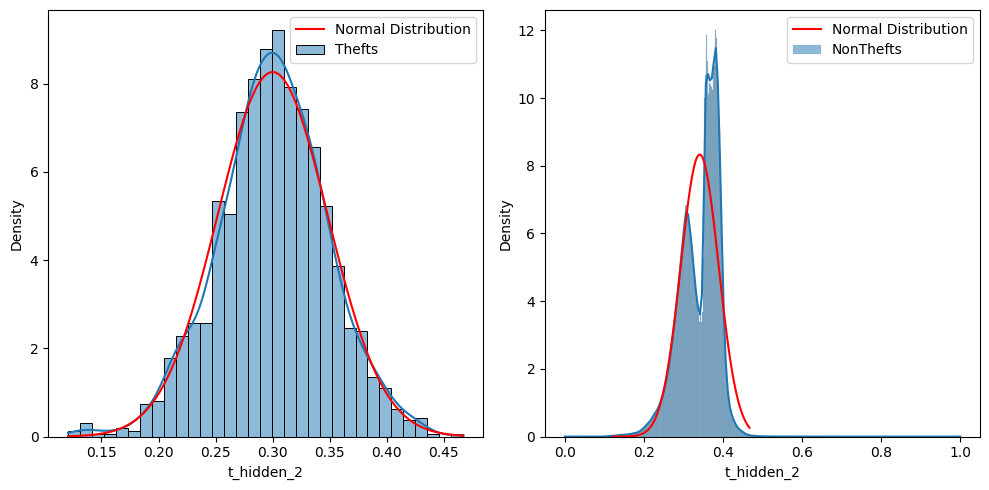

col: t_hidden_3
--
THEFTS:
min=0.10407022028045765, max=0.6299581571570929, mean=0.2720258799026282
mode=0.10407022028045765, kurtosis=2.7232568669559956, skew=1.0933627213932393

NON-THEFTS:
min=0.0, max=1.0000000000000002, mean=0.24201421658102892
mode=0.16839792130411546, kurtosis=4.546535016898639, skew=1.4623885448431284
--


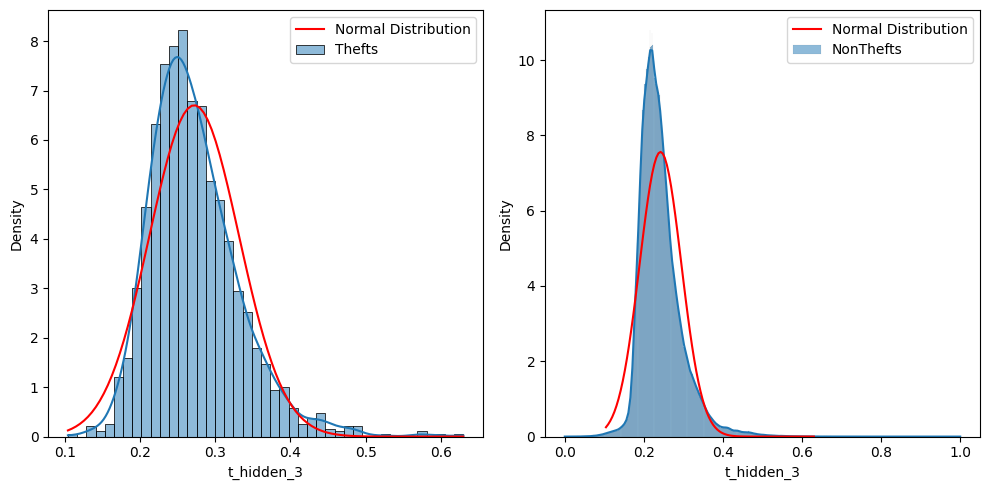

col: t_hidden_4
--
THEFTS:
min=0.11275423957550067, max=0.2437342327982193, mean=0.19807516233770034
mode=0.11275423957550067, kurtosis=0.49464667184724087, skew=-0.42519967408406667

NON-THEFTS:
min=0.0, max=1.0, mean=0.21637590725812775
mode=0.21832950323230035, kurtosis=12.708137181751377, skew=-0.9115750977916142
--


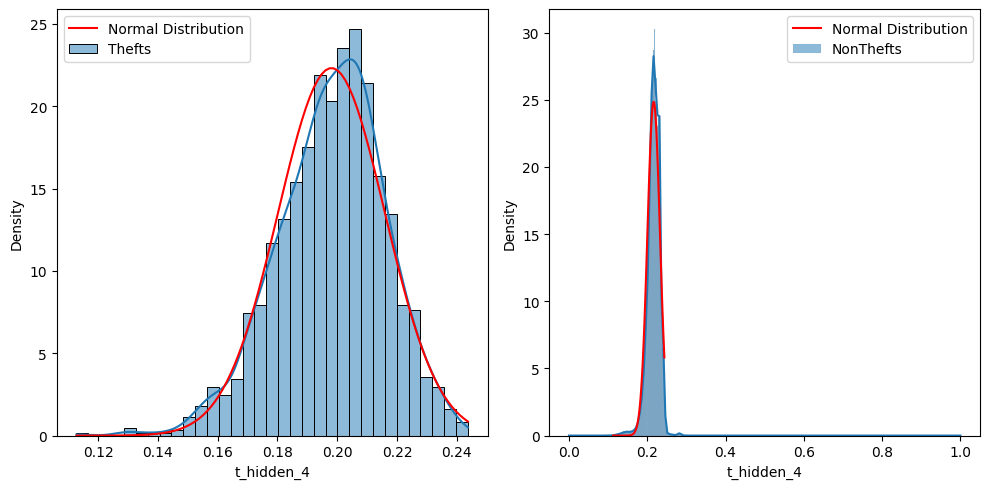

col: t_hidden_5
--
THEFTS:
min=0.7934254346175752, max=1.0, mean=0.8984172528824363
mode=0.7934254346175752, kurtosis=0.154594843084233, skew=-0.049120465427409665

NON-THEFTS:
min=0.0, max=0.9985865910517476, mean=0.891259161094191
mode=0.8911413281514393, kurtosis=13.137689115935405, skew=-2.4302080198297125
--


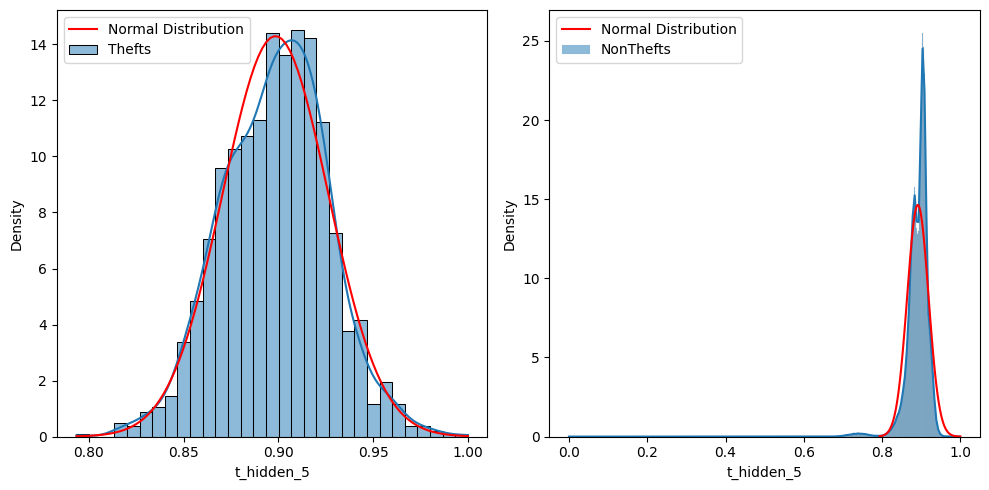

col: t_hidden_6
--
THEFTS:
min=0.008775400322153064, max=0.17591231419827252, mean=0.07337015083187944
mode=0.008775400322153064, kurtosis=0.2774934672168703, skew=0.49847065913092226

NON-THEFTS:
min=0.0, max=1.0, mean=0.0694899914865333
mode=0.06446483926821052, kurtosis=20.43120810058655, skew=2.407127097916822
--


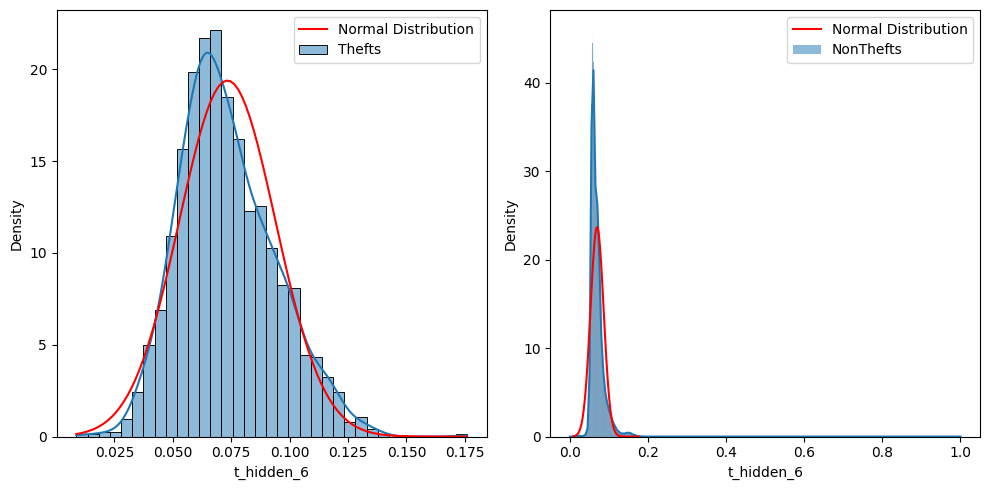

col: t_hidden_7
--
THEFTS:
min=0.6984340227889794, max=0.9311190031662194, mean=0.8290426097136143
mode=0.6984340227889794, kurtosis=1.0029061262409154, skew=-0.43596566510347046

NON-THEFTS:
min=0.0, max=1.0, mean=0.8249610563029347
mode=0.8000551711543947, kurtosis=4.942462560002616, skew=-1.359152343108385
--


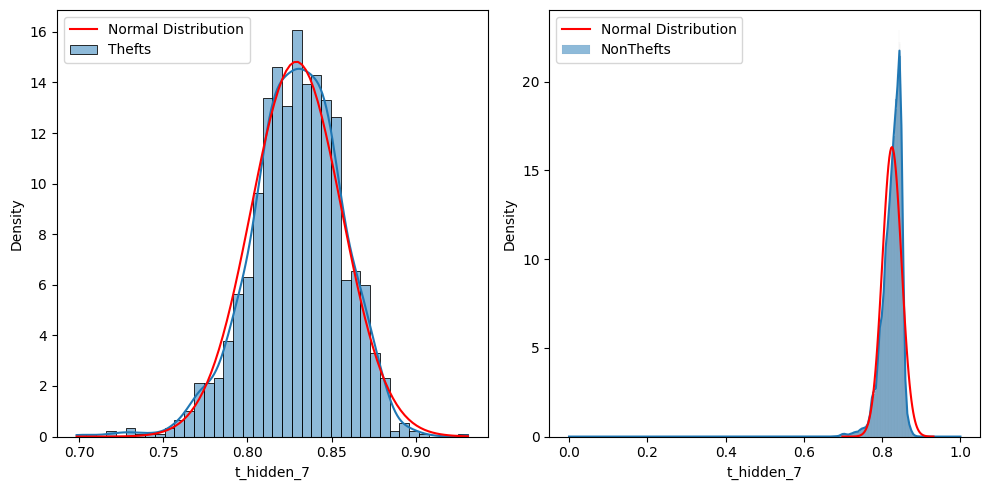

col: t_hidden_8
--
THEFTS:
min=0.04501464464698589, max=0.1830297814132493, mean=0.14492373284968124
mode=0.13618686600229726, kurtosis=4.009622340965015, skew=-1.1647047755608417

NON-THEFTS:
min=0.0, max=1.0000000000000002, mean=0.16071694232824385
mode=0.15347297050206074, kurtosis=56.03753629519408, skew=3.1733078504571597
--


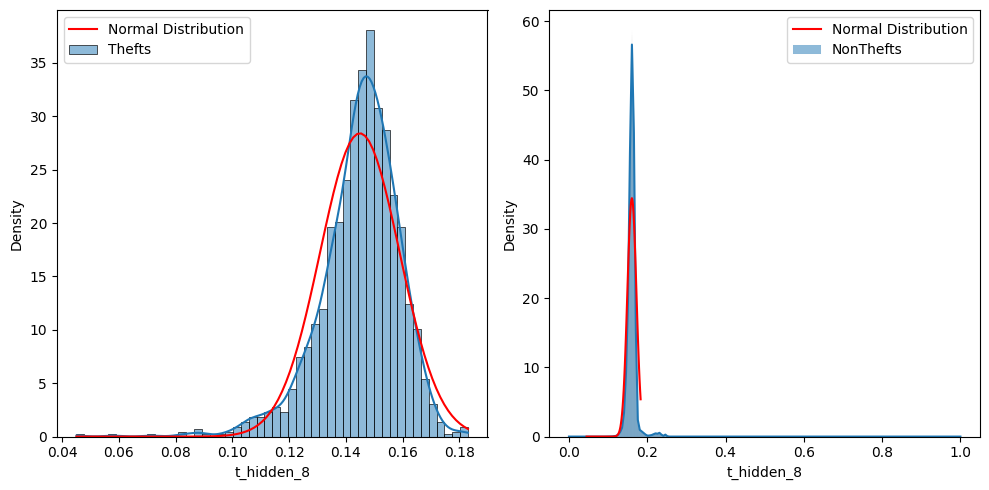

col: t_hidden_9
--
THEFTS:
min=0.5698288491519602, max=0.7269274809337968, mean=0.6496608054883924
mode=0.5698288491519602, kurtosis=0.5528363965738379, skew=-0.24822144983897587

NON-THEFTS:
min=0.0, max=1.0, mean=0.6499237480205085
mode=0.6300742758210055, kurtosis=3.7624069900421575, skew=0.112116728930288
--


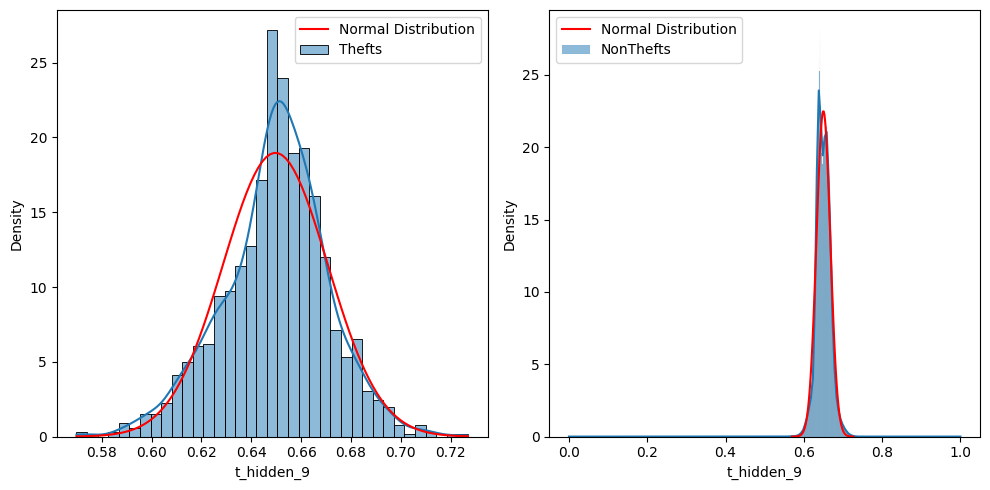

col: t_hidden_10
--
THEFTS:
min=0.22708749359079544, max=0.32740718087549936, mean=0.27914572292419915
mode=0.22708749359079544, kurtosis=0.09024932711545475, skew=-0.45219982669465736

NON-THEFTS:
min=0.0, max=1.0, mean=0.2960325414097526
mode=0.28746787777731075, kurtosis=26.31897410196496, skew=-0.2908155122025914
--


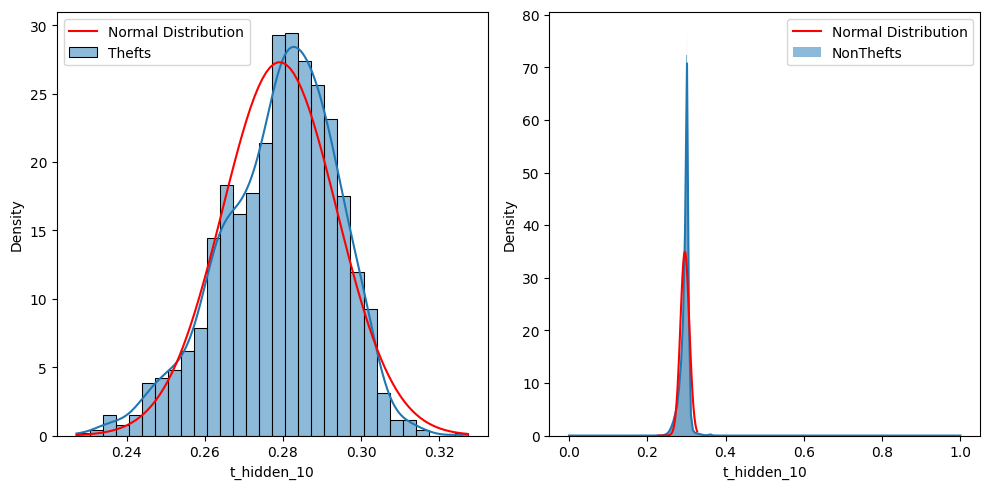

col: t_hidden_11
--
THEFTS:
min=0.07639480208515738, max=0.48205799760664525, mean=0.20724045965269305
mode=0.07639480208515738, kurtosis=1.5284968308927227, skew=0.7762680072366682

NON-THEFTS:
min=0.0, max=1.0, mean=0.17466146017258855
mode=0.1473141100735831, kurtosis=2.6185656987015506, skew=1.1049320070444562
--


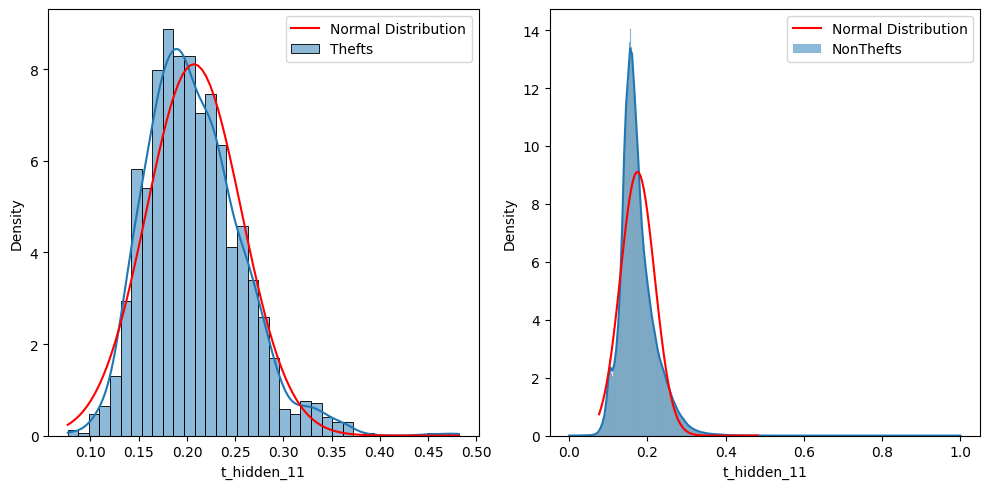

col: t_hidden_12
--
THEFTS:
min=0.5295697404289759, max=0.6769298675140986, mean=0.5898443415418585
mode=0.5295697404289759, kurtosis=1.3557712357416905, skew=0.41212926698884667

NON-THEFTS:
min=0.0, max=1.0, mean=0.5823097931610118
mode=0.5649620001883229, kurtosis=8.771766912587712, skew=0.44663398857693243
--


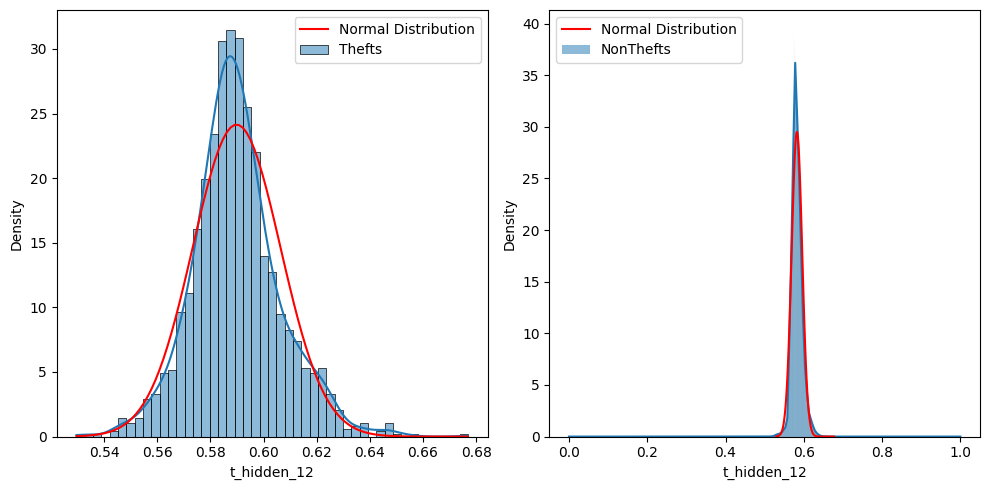

col: t_hidden_13
--
THEFTS:
min=0.16615556578647978, max=0.48306943002729913, mean=0.2792228432477994
mode=0.16615556578647978, kurtosis=1.4060223125451858, skew=0.8610874651654482

NON-THEFTS:
min=0.0, max=0.9999999999999999, mean=0.25375325499207796
mode=0.20570877637592316, kurtosis=6.129940231248666, skew=0.05454636382347248
--


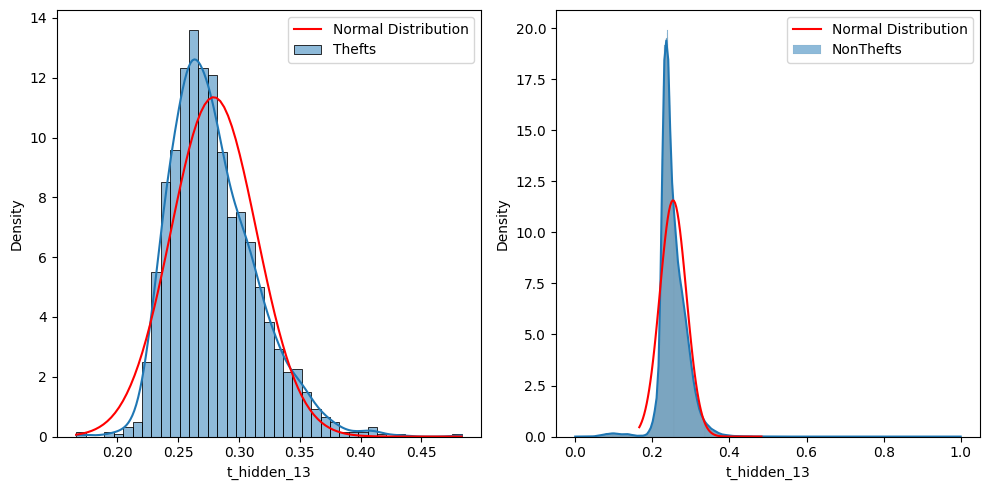

col: t_hidden_14
--
THEFTS:
min=0.41370111806439025, max=0.6605083206022992, mean=0.5141100229983502
mode=0.41370111806439025, kurtosis=0.5976175425136416, skew=0.6139889102024685

NON-THEFTS:
min=0.0, max=1.0, mean=0.5302748351747572
mode=0.5294950809739255, kurtosis=6.188511989496234, skew=1.737697055940177
--


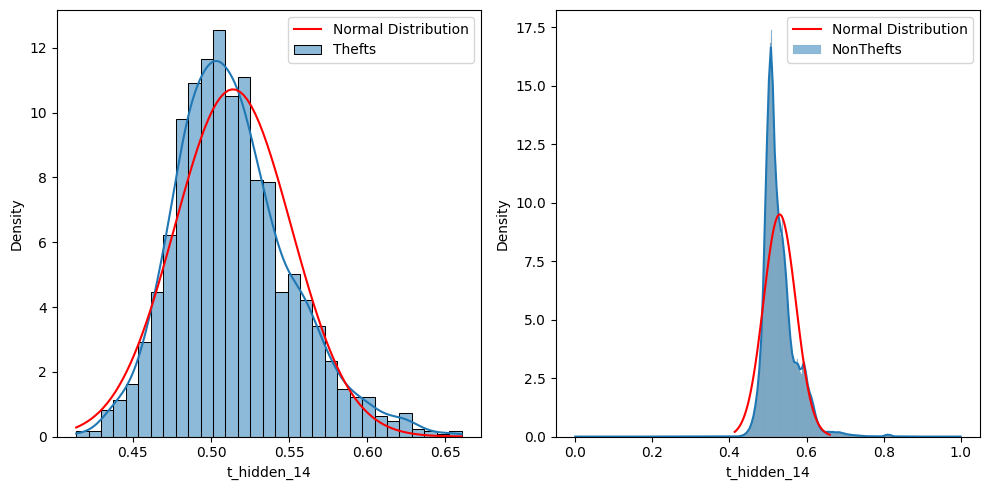

col: t_hidden_15
--
THEFTS:
min=0.031137006062436565, max=0.11956665967294894, mean=0.08918404694478536
mode=0.031137006062436565, kurtosis=1.0668069059579302, skew=-0.6753265883241355

NON-THEFTS:
min=0.0, max=1.0, mean=0.10198938788645011
mode=0.099710073767083, kurtosis=168.66446498340244, skew=5.315176541661865
--


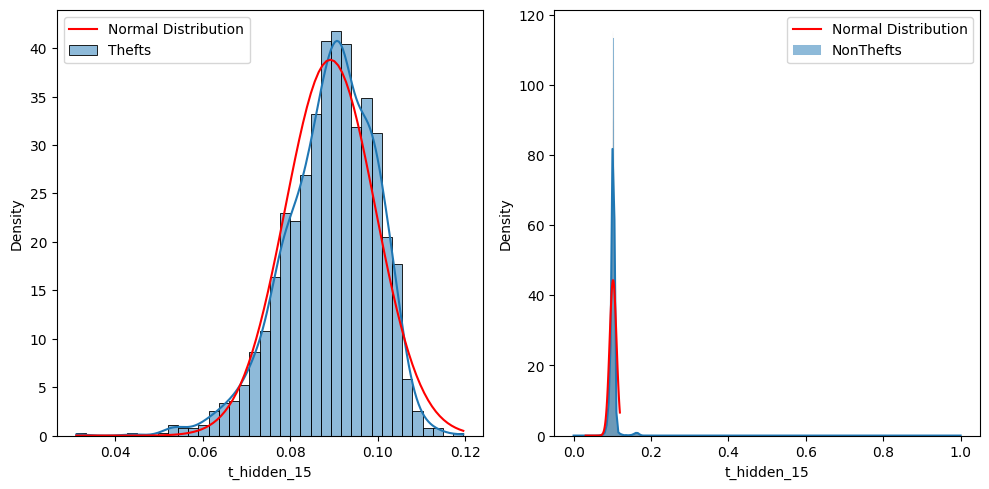

col: t_hidden_16
--
THEFTS:
min=0.015086483742963827, max=0.11770086145601108, mean=0.05595818603911633
mode=0.015086483742963827, kurtosis=0.008369230330953936, skew=0.0006171357817934674

NON-THEFTS:
min=0.0, max=1.0, mean=0.0670303289836745
mode=0.06603124148700817, kurtosis=86.9136362112161, skew=2.84100963716052
--


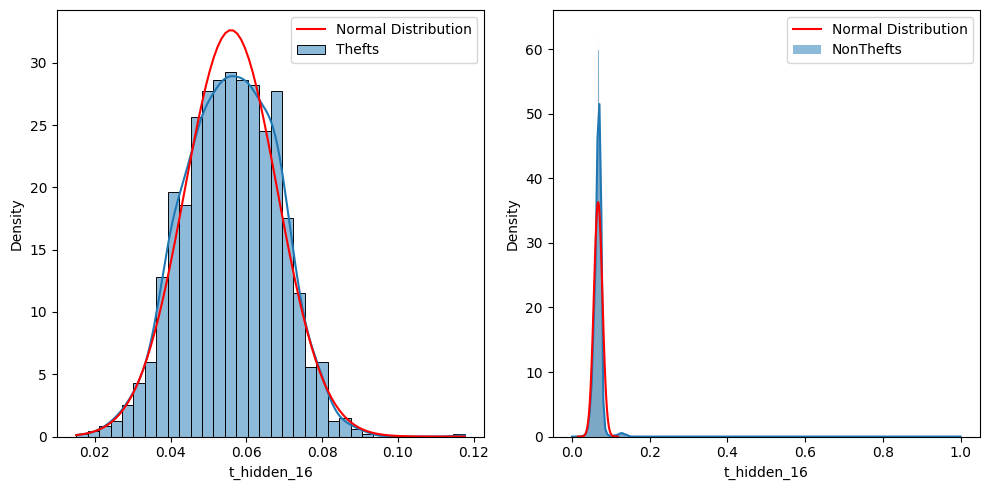

col: t_hidden_17
--
THEFTS:
min=0.018679297204425897, max=0.11546537939694142, mean=0.06412130775921752
mode=0.018679297204425897, kurtosis=0.9891414509098913, skew=-0.552223924378802

NON-THEFTS:
min=0.0, max=1.0, mean=0.07016829987717761
mode=0.07465488269050209, kurtosis=99.22089754301477, skew=2.0145983545198236
--


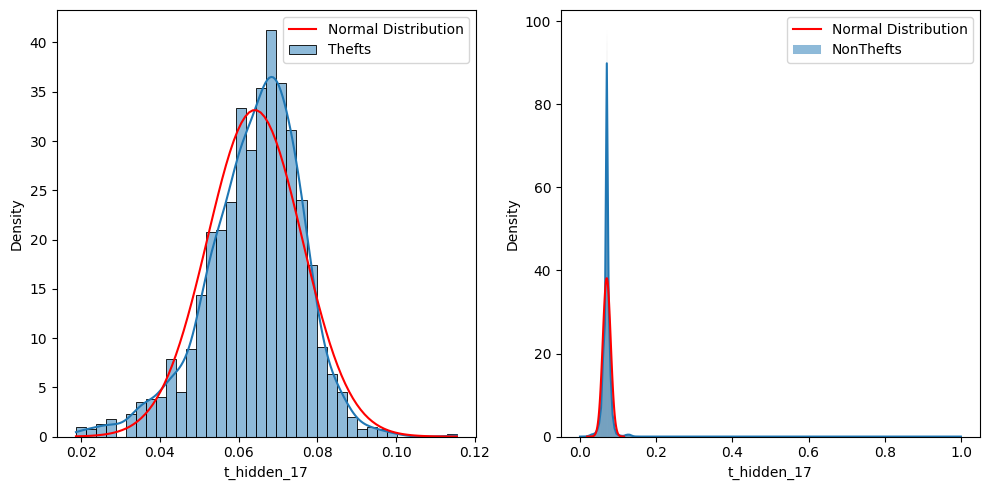

col: t_hidden_18
--
THEFTS:
min=0.17945868359044737, max=0.3533805619684185, mean=0.26262085893343534
mode=0.17945868359044737, kurtosis=1.1807123340423433, skew=-0.250279064710386

NON-THEFTS:
min=0.0, max=1.0, mean=0.24550037402116767
mode=0.20403575749647082, kurtosis=0.6859576374270238, skew=-0.05012370581767165
--


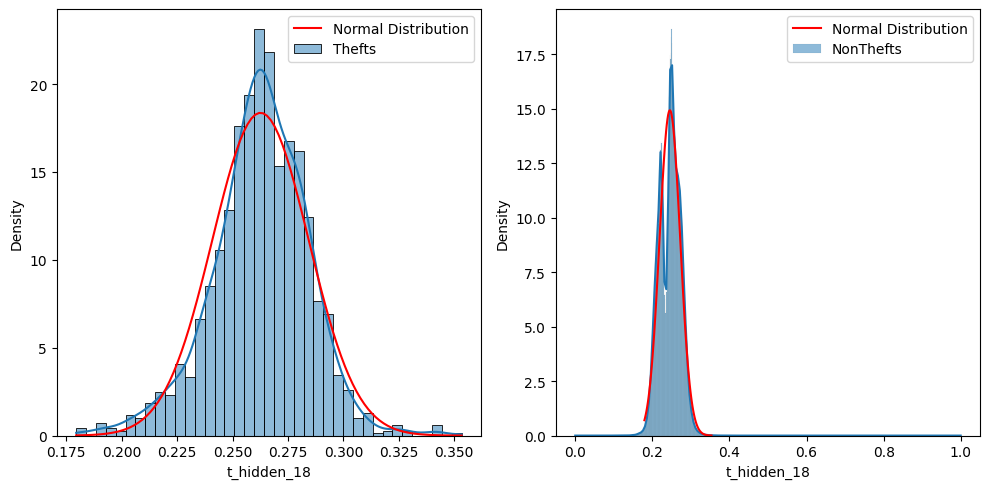

col: t_hidden_19
--
THEFTS:
min=0.23789877217051927, max=0.3277187966651316, mean=0.29467546546424467
mode=0.23789877217051927, kurtosis=0.6637959185728848, skew=-0.3744069764016781

NON-THEFTS:
min=0.0, max=1.0, mean=0.3059274187730422
mode=0.31959672154665486, kurtosis=41.011530800142474, skew=1.571252224259962
--


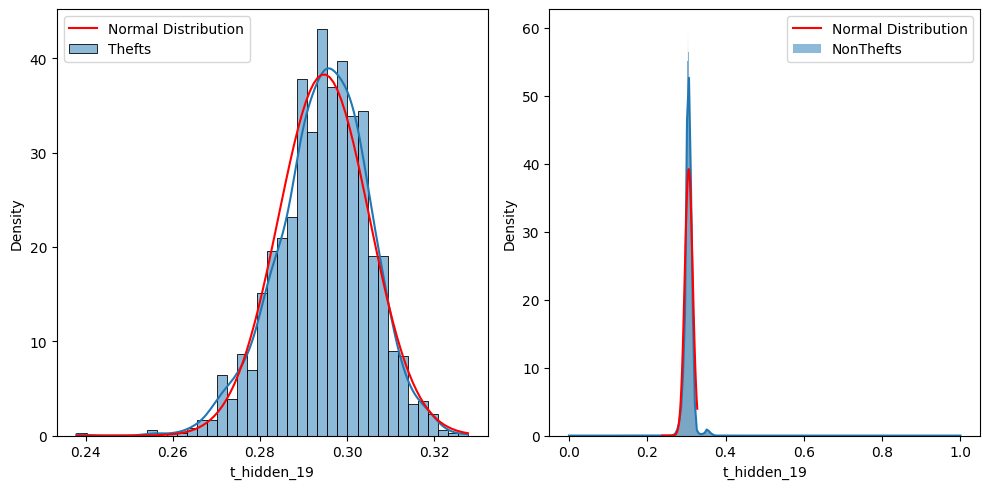

col: t_hidden_20
--
THEFTS:
min=0.7873441218891843, max=0.9701999647044816, mean=0.893152201014293
mode=0.7873441218891843, kurtosis=0.954813861385504, skew=-0.770702717010181

NON-THEFTS:
min=0.0, max=1.0, mean=0.8956495513879651
mode=0.9066559187113893, kurtosis=3.8841595364896473, skew=-1.2812646227020614
--


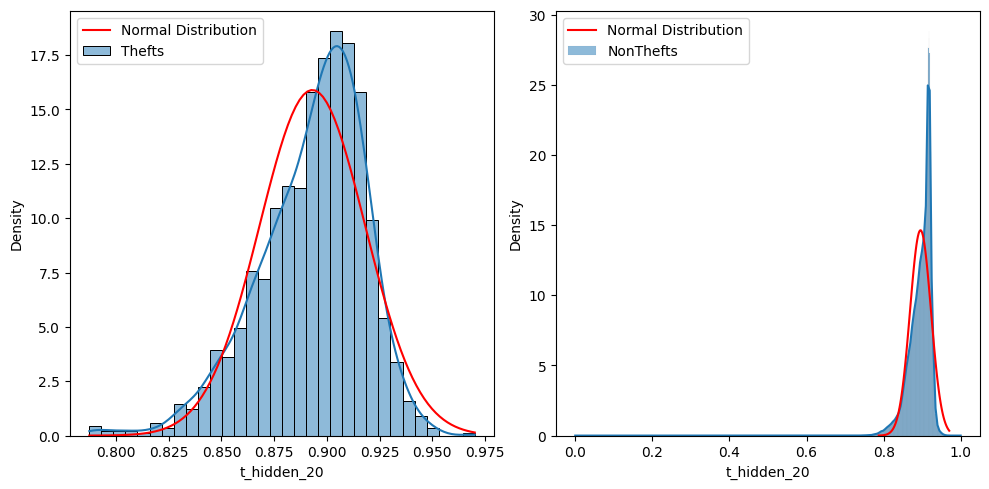

col: t_hidden_21
--
THEFTS:
min=0.06008850286851694, max=0.49400029672297463, mean=0.2115221389965676
mode=0.06008850286851694, kurtosis=1.9977684319538622, skew=0.4530655380000136

NON-THEFTS:
min=0.0, max=0.9999999999999999, mean=0.19031511096474843
mode=0.17419464526792144, kurtosis=2.365084215936023, skew=0.8812032999410232
--


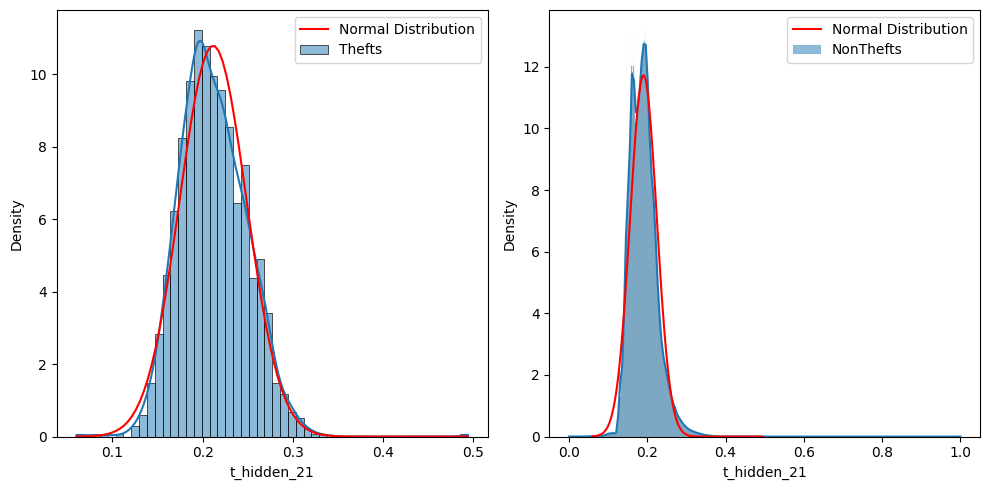

col: t_hidden_22
--
THEFTS:
min=0.83369712772067, max=1.0, mean=0.9290257481002479
mode=0.83369712772067, kurtosis=0.7905898665405648, skew=-0.17464836707468412

NON-THEFTS:
min=0.0, max=0.9850344618691604, mean=0.91669546871123
mode=0.9264007145118134, kurtosis=21.00994177099983, skew=-3.1489190555395243
--


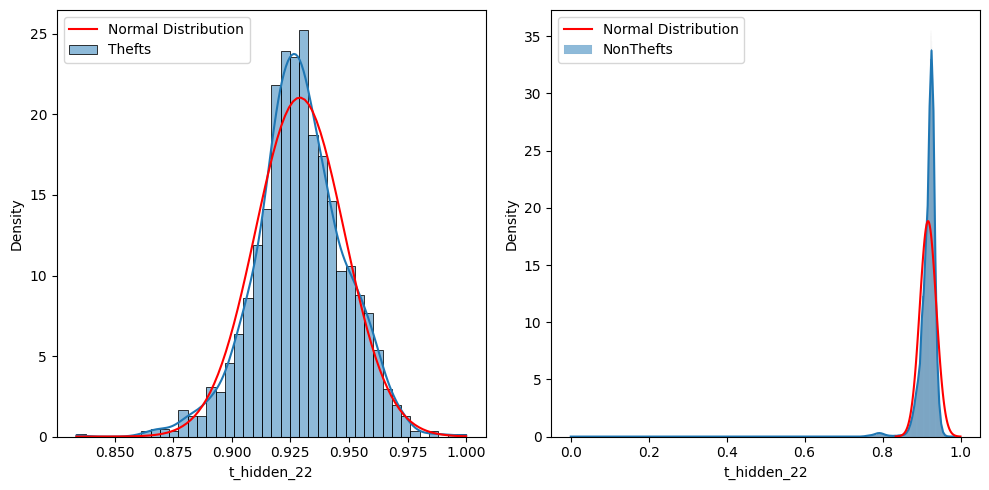

col: t_hidden_23
--
THEFTS:
min=0.0, max=0.13889255836408465, mean=0.08459321208010594
mode=0.0, kurtosis=0.7980891454003247, skew=-0.36371371559086557

NON-THEFTS:
min=0.019296130153305655, max=1.0, mean=0.09548749735720467
mode=0.05920631417577381, kurtosis=17.79005382968423, skew=0.8051505874400087
--


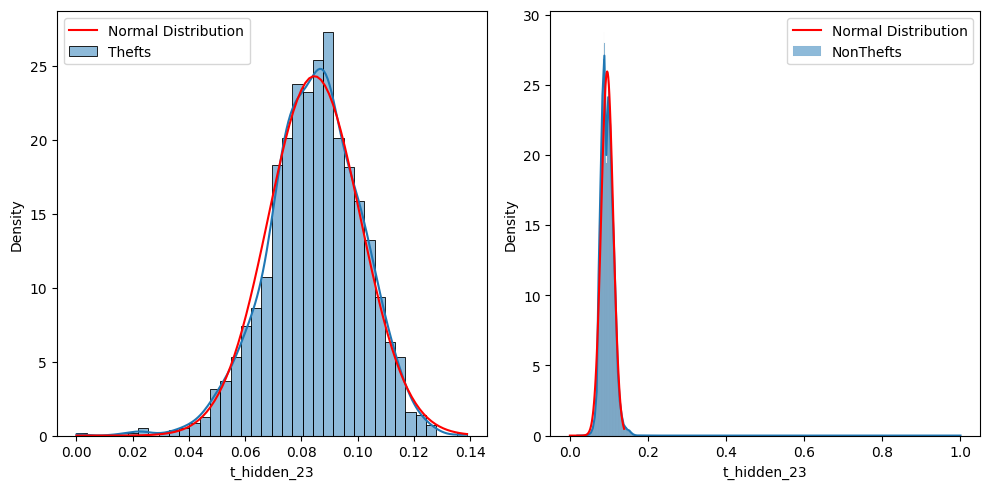

col: t_hidden_24
--
THEFTS:
min=0.0, max=0.17378892795976383, mean=0.0841107010645777
mode=0.0, kurtosis=1.1485711191684937, skew=-0.16728942537045038

NON-THEFTS:
min=0.01436524432173468, max=1.0, mean=0.09306566808194427
mode=0.08804340376671746, kurtosis=75.65978192552174, skew=1.6814017556259702
--


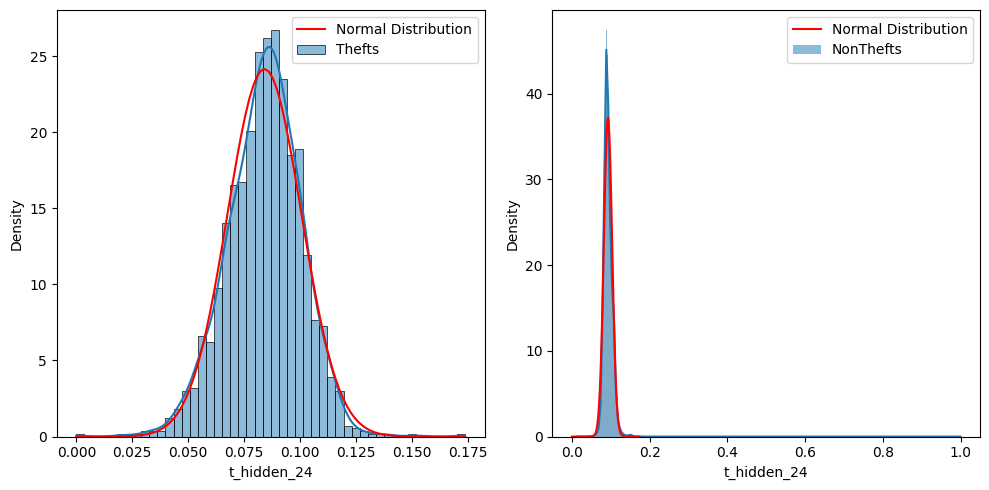

col: t_hidden_25
--
THEFTS:
min=0.0, max=0.10603194290439497, mean=0.04208708469682384
mode=0.0, kurtosis=0.4662547776305952, skew=0.05278466126874359

NON-THEFTS:
min=0.0006269941981565837, max=0.9999999999999999, mean=0.053143830351687765
mode=0.048573666969180654, kurtosis=245.7683416765924, skew=3.5620121761916534
--


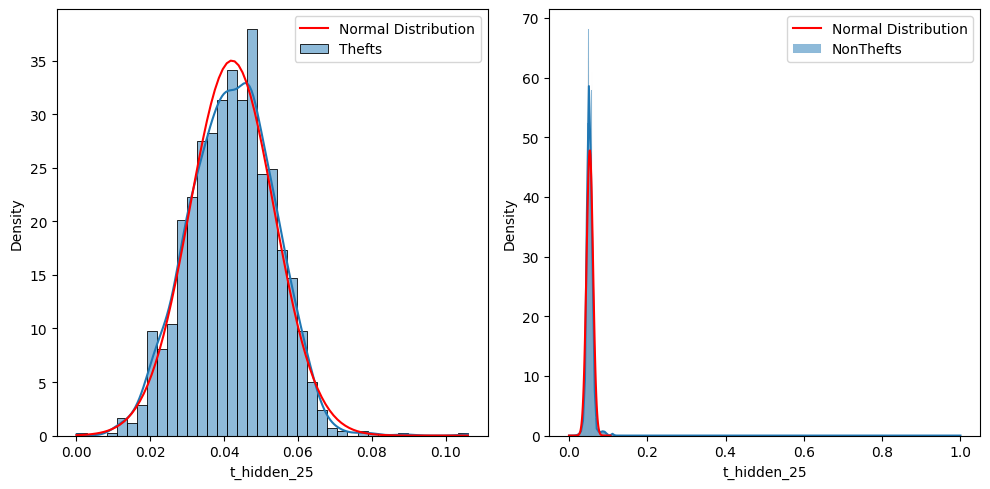

col: t_hidden_26
--
THEFTS:
min=0.8878237508906015, max=0.9835540881265317, mean=0.9410056712854215
mode=0.8878237508906015, kurtosis=0.6572049373968509, skew=-0.08085320760319618

NON-THEFTS:
min=0.0, max=1.0, mean=0.9301627830102054
mode=0.9392361142554114, kurtosis=59.635555153849744, skew=-1.0341593116226542
--


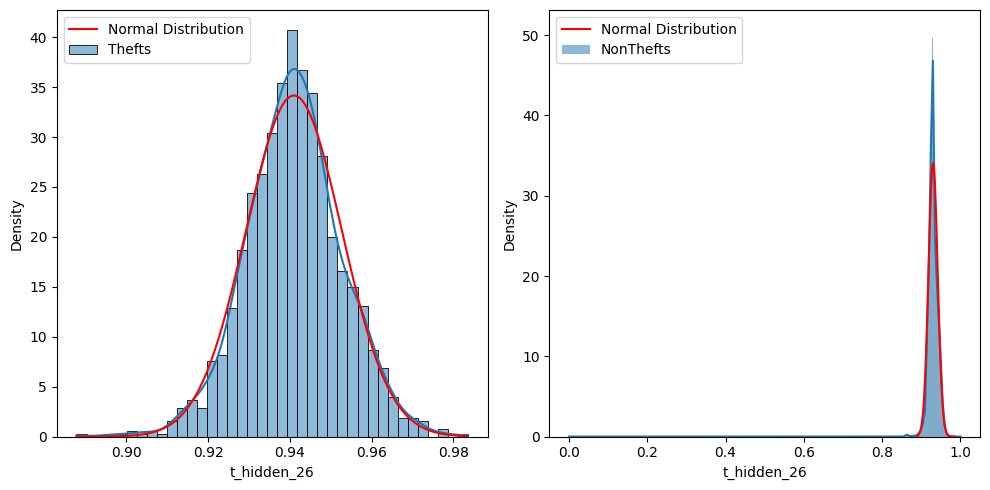

col: t_hidden_27
--
THEFTS:
min=0.4760935228072573, max=0.9007312984008057, mean=0.7166831889607371
mode=0.4760935228072573, kurtosis=1.301413145529016, skew=-0.34150654018634685

NON-THEFTS:
min=0.0, max=1.0, mean=0.7219257954074182
mode=0.6634155219851046, kurtosis=8.832247489056773, skew=0.5393061437168253
--


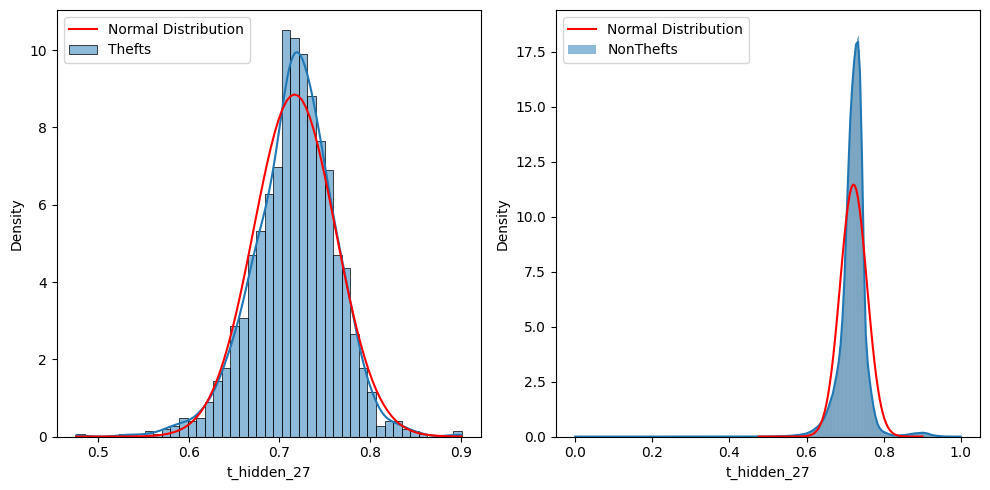

col: t_hidden_28
--
THEFTS:
min=0.01572604225619384, max=0.14566921682183115, mean=0.08041087201449557
mode=0.01572604225619384, kurtosis=0.25959329438038825, skew=-0.19519117685683868

NON-THEFTS:
min=0.0, max=0.9999999999999999, mean=0.08754324928917531
mode=0.11850616913764819, kurtosis=27.24736545021704, skew=-0.18751994090647728
--


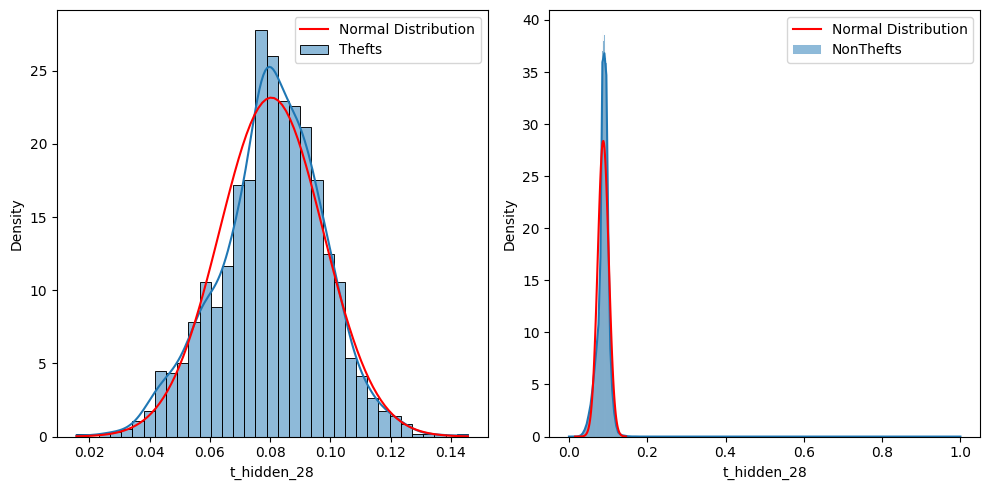

col: t_hidden_29
--
THEFTS:
min=0.20614552681261433, max=0.4276916668947506, mean=0.2959704686684893
mode=0.20614552681261433, kurtosis=0.8306950637266617, skew=0.5990350215185704

NON-THEFTS:
min=0.0, max=1.0, mean=0.27447986554023684
mode=0.23947823867985196, kurtosis=10.41550049376832, skew=2.054195006706067
--


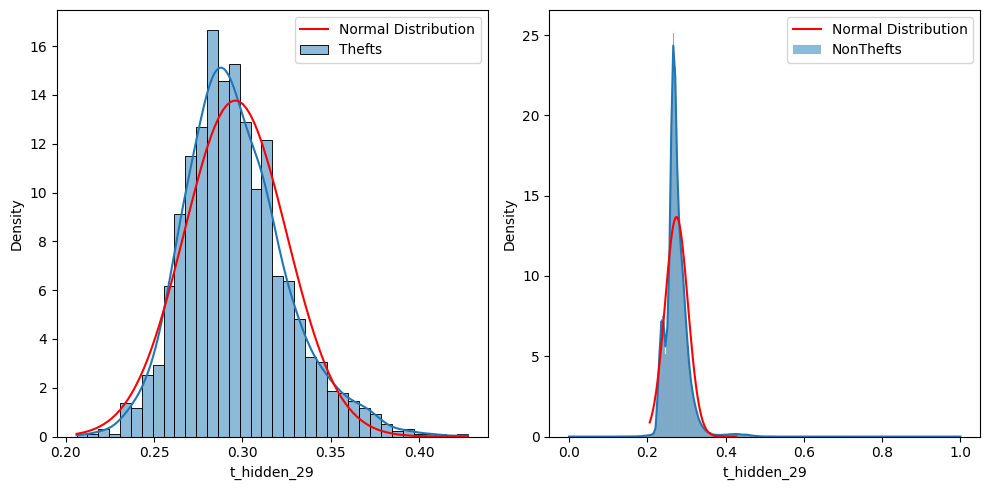

col: t_hidden_30
--
THEFTS:
min=0.0974352107089544, max=0.21104013009098466, mean=0.16057635625205996
mode=0.0974352107089544, kurtosis=0.4061197924257436, skew=-0.5921213309952831

NON-THEFTS:
min=0.0, max=1.0, mean=0.18680835430569828
mode=0.1986205230998328, kurtosis=8.137075803115765, skew=-0.29726633552790305
--


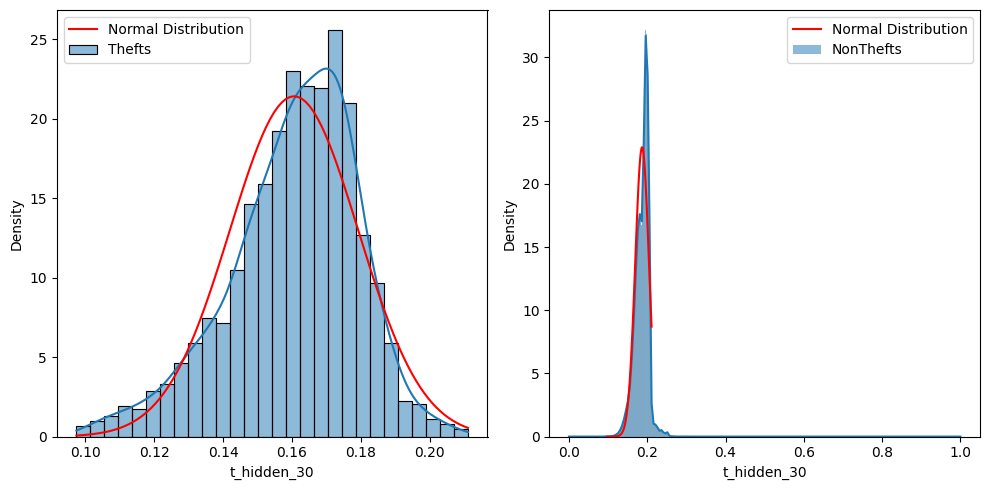

col: t_hidden_31
--
THEFTS:
min=0.8234843492530003, max=1.0, mean=0.9023141265945785
mode=0.8234843492530003, kurtosis=2.077021150978323, skew=0.40893120751721324

NON-THEFTS:
min=0.0, max=0.9698084242479627, mean=0.8962816599902346
mode=0.9214793363924523, kurtosis=31.35384638129605, skew=-0.6630579841170692
--


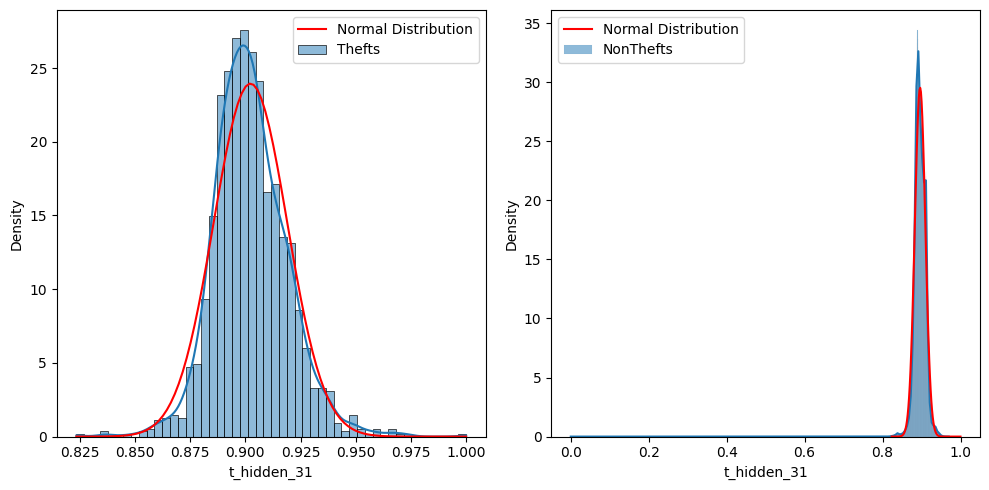

col: t_hidden_32
--
THEFTS:
min=0.8766785494124611, max=0.9643943080314392, mean=0.9196573476592291
mode=0.9063275205738314, kurtosis=0.07832439620663667, skew=0.16630120472730262

NON-THEFTS:
min=0.0, max=1.0, mean=0.9054834225390804
mode=0.8980079085876204, kurtosis=108.16292432257133, skew=-3.2177071698047417
--


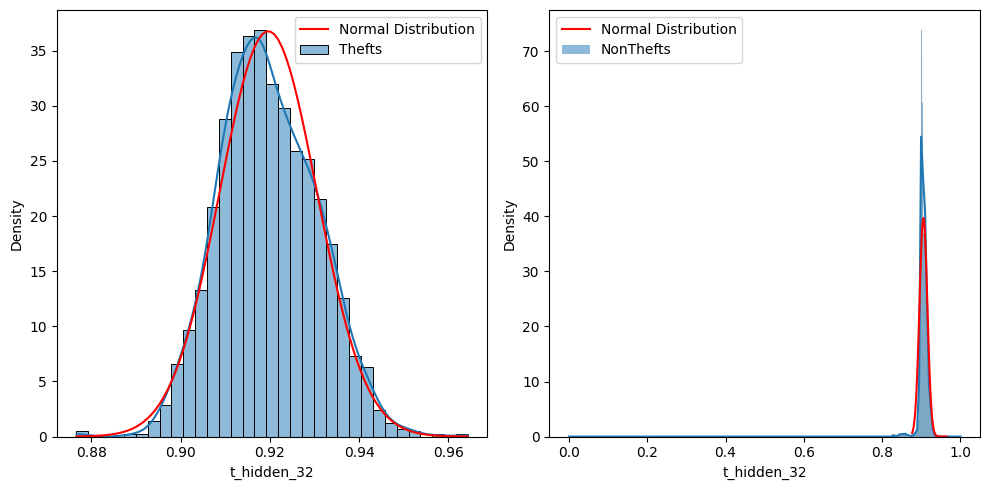

In [12]:
for col in tmp.columns:
    if col in columns_to_visualize or str(col).startswith('t_hidden'):
        plot_dist(thefts, non_thefts, col)

# Train Only with Encoded features

In [13]:
tmp_df = df.copy()
tmp_df = df[['t_hidden_1', 't_hidden_2', 't_hidden_3', 't_hidden_4',
          't_hidden_5', 't_hidden_6', 't_hidden_7', 't_hidden_8',
          't_hidden_9', 't_hidden_10', 't_hidden_11', 't_hidden_12',
          't_hidden_13', 't_hidden_14', 't_hidden_15', 't_hidden_16',
          't_hidden_17', 't_hidden_18', 't_hidden_19', 't_hidden_20',
          't_hidden_21', 't_hidden_22', 't_hidden_23', 't_hidden_24',
          't_hidden_25', 't_hidden_26', 't_hidden_27', 't_hidden_28',
          't_hidden_29', 't_hidden_30', 't_hidden_31', 't_hidden_32',
            'target']]

In [14]:
tmp_df.head()

t_hidden_1  t_hidden_2  t_hidden_3  t_hidden_4  t_hidden_5  t_hidden_6  \
0   -0.408745    0.019283    0.875199    1.236878   -0.909931    1.124214   
1    1.261450    0.385389    0.524206    0.335333   -1.855268    0.905791   
2    0.631862    1.284966    0.219037    1.735167   -0.802665    0.234240   
3   -0.533879   -0.300280    0.737864    0.519675   -0.304382    1.147514   
4   -1.051911    0.350452    0.194913    0.542731    0.227543    0.751633   

   t_hidden_7  t_hidden_8  t_hidden_9  t_hidden_10  ...  t_hidden_24  \
0   -0.485348    0.343595    0.063377     0.383679  ...     2.361559   
1    0.010550   -0.675372    1.666657    -0.492278  ...     0.836465   
2   -0.200826    0.336721    0.557764    -0.086913  ...     2.336785   
3   -0.642419   -0.139555   -0.968210    -0.300562  ...     0.869136   
4    0.859556   -1.049925   -0.084372    -0.033673  ...     0.602726   

   t_hidden_25  t_hidden_26  t_hidden_27  t_hidden_28  t_hidden_29  \
0     1.938654    -0.574741    -1.066690     0.023123    -0.041047   
1     1.691065     0.117468    -0.533461    -0.163281     0.552240   
2     2.482246    -1.427288    -0.665344    -0.566080    -1.438796   
3     1.958137    -0.506930    -1.264389    -0.298342    -0.625637   
4     1.124325     0.165342    -0.799687     0.135509    -0.275075   

   t_hidden_30  t_hidden_31  t_hidden_32  target  
0     0.218051    -1.160616    -1.216362     0.0  
1    -0.471347    -0.875878    -0.599580     0.0  
2     0.712387     0.779548    -0.954446     0.0  
3    -0.404670     0.399970    -0.899167     0.0  
4     0.080667     0.015887     0.094562     0.0  

[5 rows x 33 columns]

Classifier: CATBOOST
Number of samples: 700519
Data bins [698967   1552]
Shape (560415, 32)
bins [559173   1242]
bins [139794    310]
0.1 -- Lift: 0.8065, Demotion: 1.0000, Weighted: 0.8645
0.2 -- Lift: 0.5806, Demotion: 1.0000, Weighted: 0.7065
0.3 -- Lift: 0.4301, Demotion: 1.0000, Weighted: 0.6011
0.4 -- Lift: 0.3387, Demotion: 1.0000, Weighted: 0.5371
0.5 -- Lift: 0.2839, Demotion: 1.0000, Weighted: 0.4987
0.6 -- Lift: 0.2419, Demotion: 1.0000, Weighted: 0.4694
0.7 -- Lift: 0.2166, Demotion: 1.0000, Weighted: 0.4516
0.8 -- Lift: 0.1976, Demotion: 1.0000, Weighted: 0.4383
0.9 -- Lift: 0.1900, Demotion: 1.0000, Weighted: 0.4330
1 -- Lift: 0.1806, Demotion: 1.0000, Weighted: 0.4265
Fold 1 - Accuracy: 0.9979, Precision: 0.7391, Recall: 0.1097, F1: 0.1910, Brier: 0.0020, AUC-ROC: 0.8893, PR-AUC: 0.1390, Lift: 0.3387, Demotion: 1.0000, Weighted: 0.5371


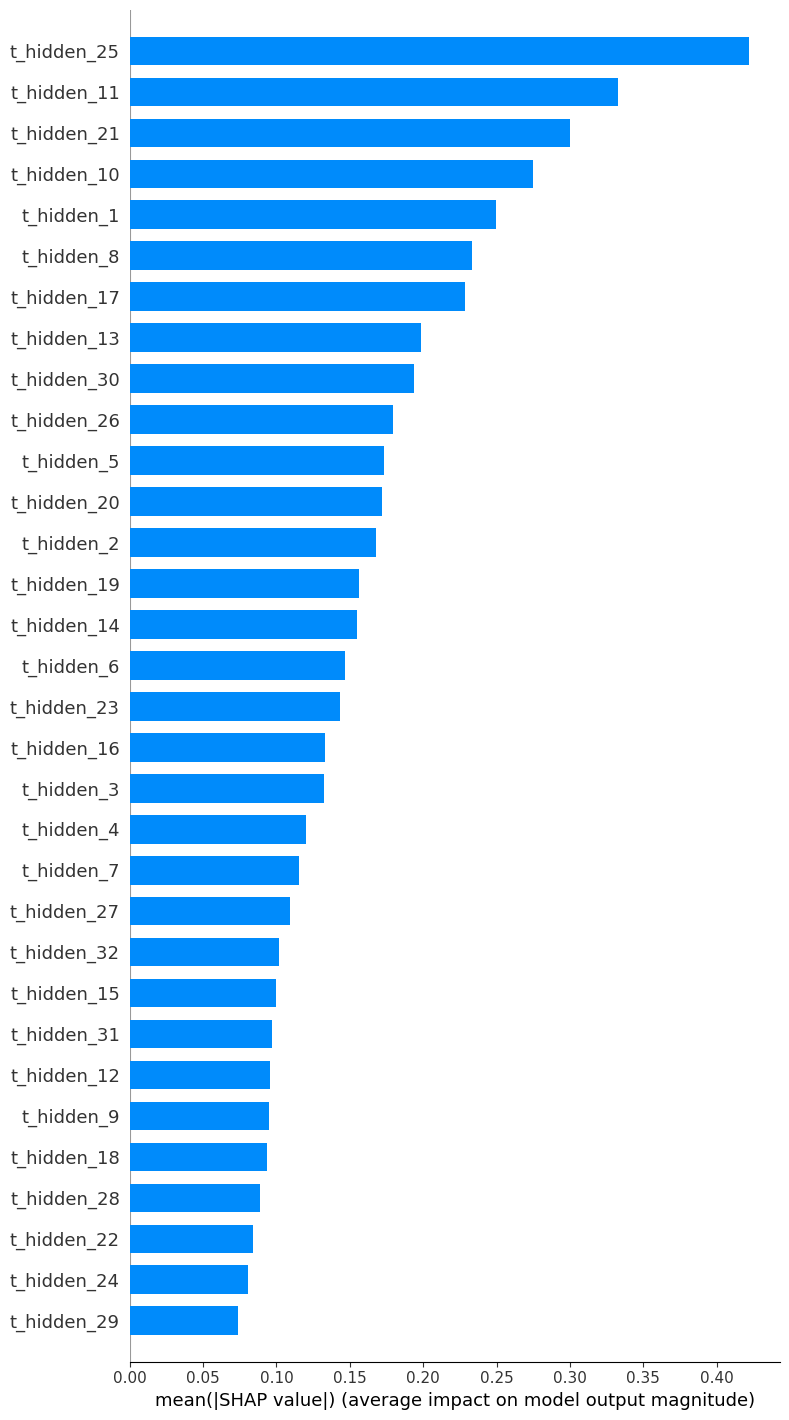

Shape (560415, 32)
bins [559173   1242]
bins [139794    310]
0.1 -- Lift: 0.8065, Demotion: 1.0000, Weighted: 0.8645
0.2 -- Lift: 0.4839, Demotion: 1.0000, Weighted: 0.6387
0.3 -- Lift: 0.3871, Demotion: 1.0000, Weighted: 0.5710
0.4 -- Lift: 0.3306, Demotion: 1.0000, Weighted: 0.5315
0.5 -- Lift: 0.2903, Demotion: 1.0000, Weighted: 0.5032
0.6 -- Lift: 0.2742, Demotion: 1.0000, Weighted: 0.4919
0.7 -- Lift: 0.2488, Demotion: 1.0000, Weighted: 0.4742
0.8 -- Lift: 0.2258, Demotion: 1.0000, Weighted: 0.4581
0.9 -- Lift: 0.2007, Demotion: 1.0000, Weighted: 0.4405
1 -- Lift: 0.1806, Demotion: 1.0000, Weighted: 0.4265
Fold 2 - Accuracy: 0.9979, Precision: 0.8519, Recall: 0.0742, F1: 0.1365, Brier: 0.0020, AUC-ROC: 0.8943, PR-AUC: 0.1394, Lift: 0.3306, Demotion: 1.0000, Weighted: 0.5315


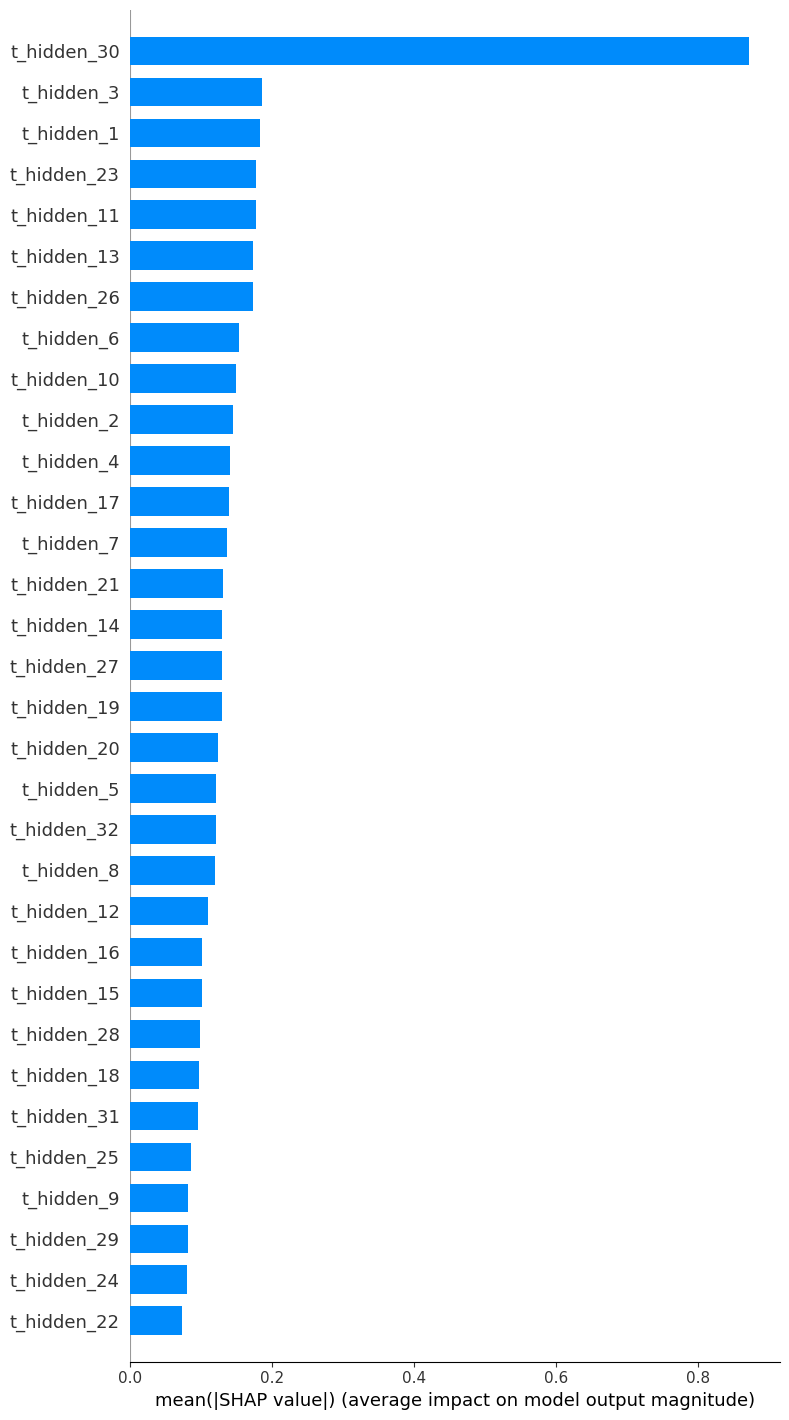

Shape (560415, 32)
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.6452, Demotion: 1.0000, Weighted: 0.7516
0.2 -- Lift: 0.4194, Demotion: 1.0000, Weighted: 0.5935
0.3 -- Lift: 0.3656, Demotion: 1.0000, Weighted: 0.5559
0.4 -- Lift: 0.3226, Demotion: 1.0000, Weighted: 0.5258
0.5 -- Lift: 0.2645, Demotion: 1.0000, Weighted: 0.4852
0.6 -- Lift: 0.2258, Demotion: 1.0000, Weighted: 0.4581
0.7 -- Lift: 0.2028, Demotion: 1.0000, Weighted: 0.4419
0.8 -- Lift: 0.1815, Demotion: 1.0000, Weighted: 0.4270
0.9 -- Lift: 0.1685, Demotion: 1.0000, Weighted: 0.4179
1 -- Lift: 0.1608, Demotion: 1.0000, Weighted: 0.4125
Fold 3 - Accuracy: 0.9978, Precision: 0.6216, Recall: 0.0740, F1: 0.1322, Brier: 0.0021, AUC-ROC: 0.8783, PR-AUC: 0.1155, Lift: 0.3226, Demotion: 1.0000, Weighted: 0.5258


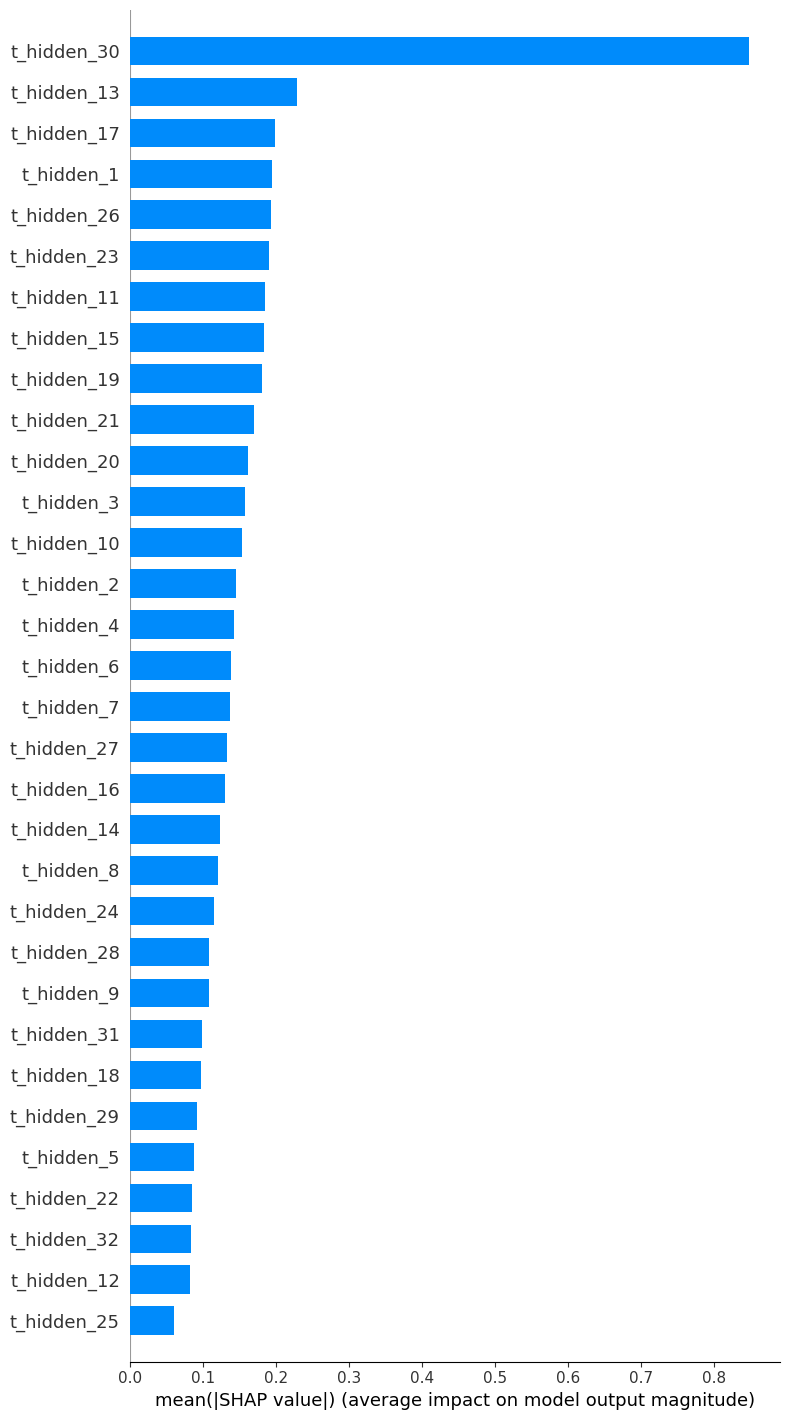

Shape (560415, 32)
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.5806, Demotion: 1.0000, Weighted: 0.7065
0.2 -- Lift: 0.4032, Demotion: 1.0000, Weighted: 0.5823
0.3 -- Lift: 0.3441, Demotion: 1.0000, Weighted: 0.5409
0.4 -- Lift: 0.2984, Demotion: 1.0000, Weighted: 0.5089
0.5 -- Lift: 0.2581, Demotion: 1.0000, Weighted: 0.4806
0.6 -- Lift: 0.2473, Demotion: 1.0000, Weighted: 0.4731
0.7 -- Lift: 0.2212, Demotion: 1.0000, Weighted: 0.4548
0.8 -- Lift: 0.2016, Demotion: 1.0000, Weighted: 0.4411
0.9 -- Lift: 0.1935, Demotion: 1.0000, Weighted: 0.4355
1 -- Lift: 0.1865, Demotion: 1.0000, Weighted: 0.4305
Fold 4 - Accuracy: 0.9978, Precision: 0.5625, Recall: 0.0579, F1: 0.1050, Brier: 0.0021, AUC-ROC: 0.8874, PR-AUC: 0.1204, Lift: 0.2984, Demotion: 1.0000, Weighted: 0.5089


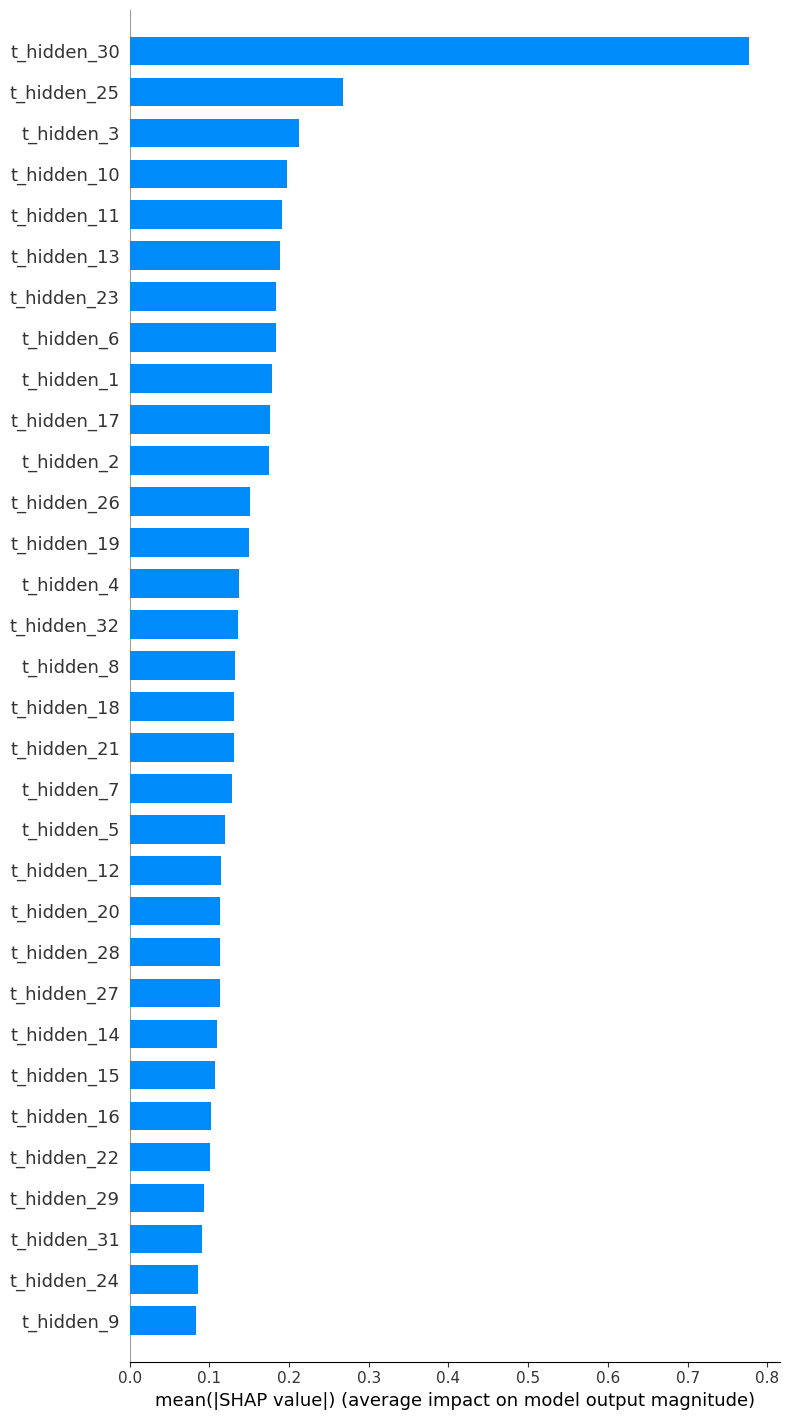

Shape (560416, 32)
bins [559174   1242]
bins [139793    310]
0.1 -- Lift: 0.5806, Demotion: 1.0000, Weighted: 0.7065
0.2 -- Lift: 0.4032, Demotion: 1.0000, Weighted: 0.5823
0.3 -- Lift: 0.3011, Demotion: 1.0000, Weighted: 0.5108
0.4 -- Lift: 0.2500, Demotion: 1.0000, Weighted: 0.4750
0.5 -- Lift: 0.2129, Demotion: 1.0000, Weighted: 0.4490
0.6 -- Lift: 0.2043, Demotion: 1.0000, Weighted: 0.4430
0.7 -- Lift: 0.1797, Demotion: 1.0000, Weighted: 0.4258
0.8 -- Lift: 0.1653, Demotion: 1.0000, Weighted: 0.4157
0.9 -- Lift: 0.1505, Demotion: 1.0000, Weighted: 0.4054
1 -- Lift: 0.1484, Demotion: 1.0000, Weighted: 0.4039
Fold 5 - Accuracy: 0.9978, Precision: 0.5862, Recall: 0.0548, F1: 0.1003, Brier: 0.0021, AUC-ROC: 0.8762, PR-AUC: 0.1068, Lift: 0.2500, Demotion: 1.0000, Weighted: 0.4750


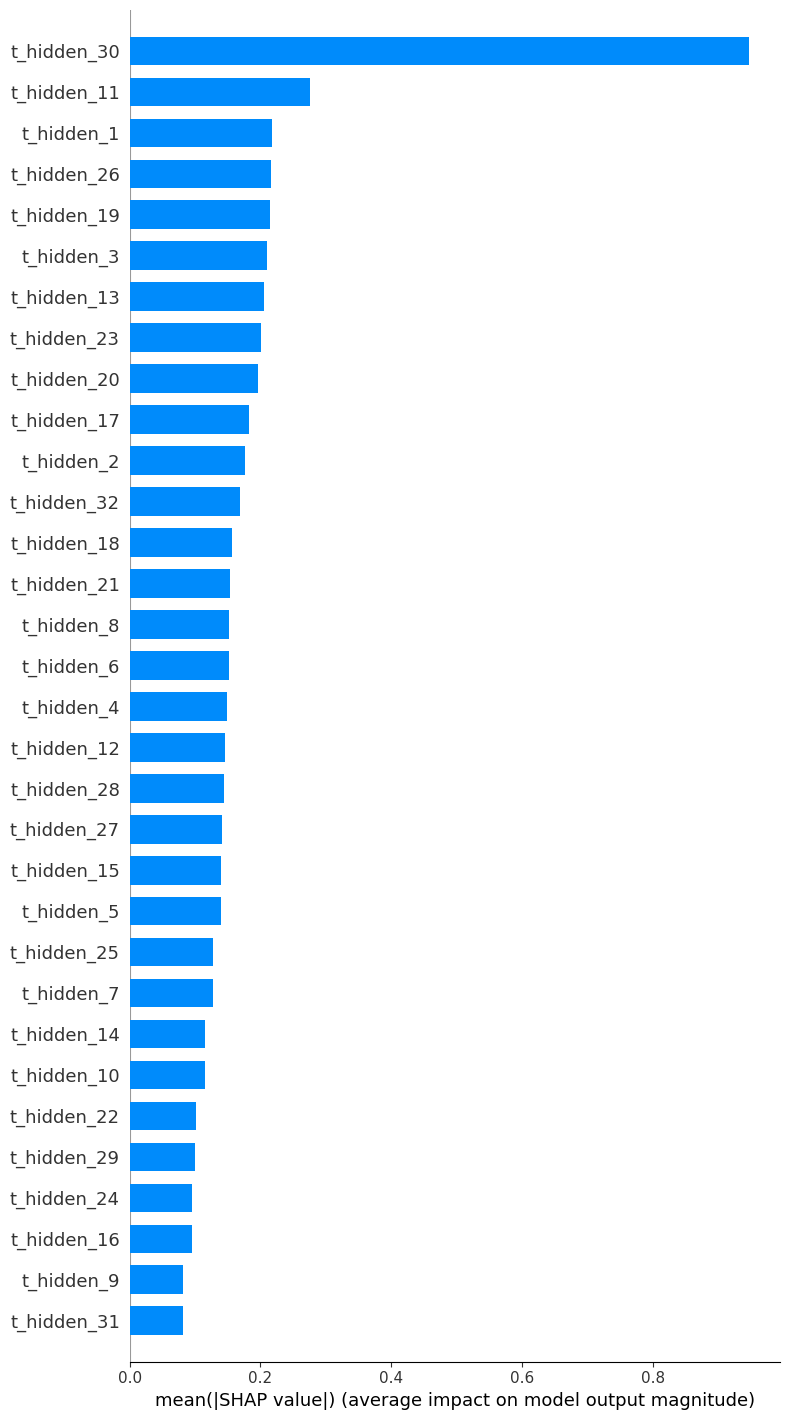

Average - Accuracy: 0.9979, Precision: 0.6723, Recall: 0.0741, F1: 0.1330, Brier: 0.0021, AUC-ROC: 0.8851, PR-AUC: 0.1242, Lift: 0.3081, Demotion: 1.0000, Weighted: 0.5156



In [15]:
clf = CatBoostClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = tmp_df.drop(['target'], axis=1)
y = tmp_df['target']
cols = list(tmp_df.columns)
cols.remove('target')
train(clf, X, y, cols)

# Train with random variables

In [16]:
tmp_df = original_df.copy()
if "auto_loss" in tmp_df.columns:
    tmp_df.drop(['auto_loss'], axis=1, inplace=True)
for i in range(32):
    col_name = f'RandomVar{i}'
    tmp_df[col_name] = np.random.normal(size=len(tmp_df))
tmp_df.head()

COUNT(consumptions)  MAX(consumptions.CSS_MS_HS_USE)  \
0                  4.0                            135.0   
1                 10.0                            127.0   
2                 12.0                           6068.0   
3                  6.0                           1061.0   
4                 24.0                           1247.0   

   MEAN(consumptions.CSS_MS_HS_USE)  MIN(consumptions.CSS_MS_HS_USE)  \
0                         64.250000                             12.0   
1                         51.900000                              0.0   
2                       3924.166667                           2446.0   
3                        479.333333                              7.0   
4                        536.833333                              0.0   

   NUM_UNIQUE(consumptions.BS_RATE)  NUM_UNIQUE(consumptions.MS_METER_NBR)  \
0                               1.0                                    1.0   
1                               1.0                                    2.0   
2                               1.0                                    1.0   
3                               2.0                                    1.0   
4                               2.0                                    1.0   

   SKEW(consumptions.CSS_MS_HS_USE)  STD(consumptions.CSS_MS_HS_USE)  \
0                          0.758461                        54.389797   
1                          0.783315                        43.072162   
2                          0.574519                      1012.516472   
3                          0.020392                       409.340282   
4                          0.537625                       335.364392   

   SUM(consumptions.CSS_MS_HS_USE)  MODE(consumptions.DAY(MEASUREMENT_DATE))  \
0                            257.0                                       2.0   
1                            519.0                                       2.0   
2                          47090.0                                      28.0   
3                           2876.0                                       4.0   
4                          12884.0                                       4.0   

   ...  RandomVar22  RandomVar23  RandomVar24  RandomVar25  RandomVar26  \
0  ...     1.109910     1.078026    -0.578910     0.869300     1.179314   
1  ...    -0.222347     0.260904     0.694297    -0.594144     0.505189   
2  ...    -1.220578    -0.538013    -0.421230    -0.606107     0.720342   
3  ...     1.200004    -0.837665    -0.352033    -0.911099     0.192949   
4  ...    -1.350395     1.041999     0.719436     0.120547    -0.672934   

   RandomVar27  RandomVar28  RandomVar29  RandomVar30  RandomVar31  
0    -1.196407     0.966677     0.917712    -0.110362     0.381331  
1    -1.496052    -0.802800    -1.518425    -0.709627    -0.464611  
2     2.418172    -0.271584    -0.126255     0.830446     0.020425  
3     2.417431    -0.145754     1.561001    -1.430963    -0.443540  
4     1.440939    -0.029593    -1.086474    -1.017824    -0.174181  

[5 rows x 121 columns]

Classifier: CATBOOST
Number of samples: 700519
Data bins [698967   1552]
Shape (560415, 120)
bins [559173   1242]
bins [139794    310]
0.1 -- Lift: 0.6452, Demotion: 1.0000, Weighted: 0.7516
0.2 -- Lift: 0.4355, Demotion: 1.0000, Weighted: 0.6048
0.3 -- Lift: 0.3548, Demotion: 1.0000, Weighted: 0.5484
0.4 -- Lift: 0.3226, Demotion: 1.0000, Weighted: 0.5258
0.5 -- Lift: 0.2968, Demotion: 1.0000, Weighted: 0.5077
0.6 -- Lift: 0.2527, Demotion: 1.0000, Weighted: 0.4769
0.7 -- Lift: 0.2258, Demotion: 1.0000, Weighted: 0.4581
0.8 -- Lift: 0.2137, Demotion: 1.0000, Weighted: 0.4496
0.9 -- Lift: 0.1971, Demotion: 1.0000, Weighted: 0.4380
1 -- Lift: 0.1903, Demotion: 1.0000, Weighted: 0.4332
Fold 1 - Accuracy: 0.9978, Precision: 0.7500, Recall: 0.0387, F1: 0.0736, Brier: 0.0021, AUC-ROC: 0.8868, PR-AUC: 0.1279, Lift: 0.3226, Demotion: 1.0000, Weighted: 0.5258


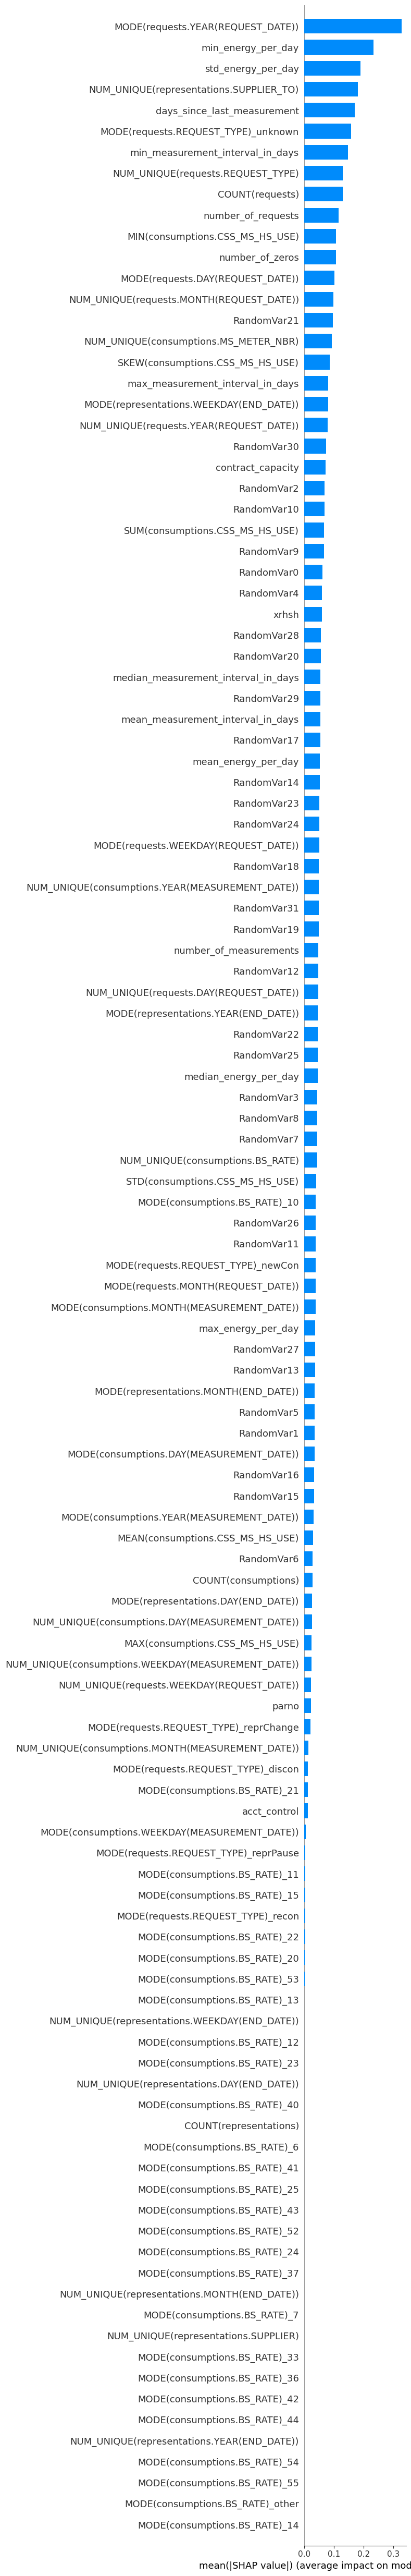

Shape (560415, 120)
bins [559173   1242]
bins [139794    310]
0.1 -- Lift: 0.5806, Demotion: 1.0000, Weighted: 0.7065
0.2 -- Lift: 0.3710, Demotion: 1.0000, Weighted: 0.5597
0.3 -- Lift: 0.3011, Demotion: 1.0000, Weighted: 0.5108
0.4 -- Lift: 0.2419, Demotion: 1.0000, Weighted: 0.4694
0.5 -- Lift: 0.2194, Demotion: 1.0000, Weighted: 0.4535
0.6 -- Lift: 0.2043, Demotion: 1.0000, Weighted: 0.4430
0.7 -- Lift: 0.1982, Demotion: 1.0000, Weighted: 0.4387
0.8 -- Lift: 0.1734, Demotion: 1.0000, Weighted: 0.4214
0.9 -- Lift: 0.1685, Demotion: 1.0000, Weighted: 0.4179
1 -- Lift: 0.1548, Demotion: 1.0000, Weighted: 0.4084
Fold 2 - Accuracy: 0.9978, Precision: 0.7333, Recall: 0.0355, F1: 0.0677, Brier: 0.0021, AUC-ROC: 0.9000, PR-AUC: 0.1046, Lift: 0.2419, Demotion: 1.0000, Weighted: 0.4694


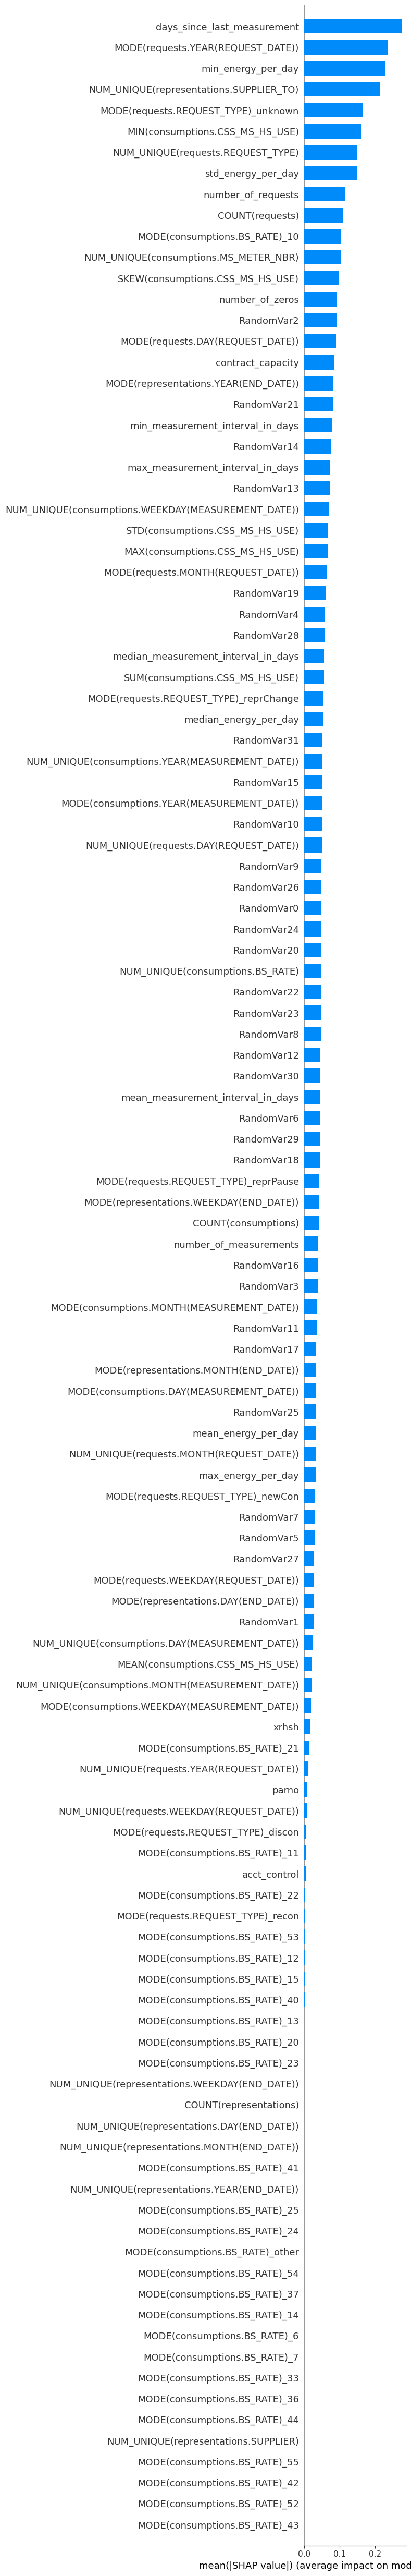

Shape (560415, 120)
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.5484, Demotion: 1.0000, Weighted: 0.6839
0.2 -- Lift: 0.3710, Demotion: 1.0000, Weighted: 0.5597
0.3 -- Lift: 0.2688, Demotion: 1.0000, Weighted: 0.4882
0.4 -- Lift: 0.2258, Demotion: 1.0000, Weighted: 0.4581
0.5 -- Lift: 0.1871, Demotion: 1.0000, Weighted: 0.4310
0.6 -- Lift: 0.1935, Demotion: 1.0000, Weighted: 0.4355
0.7 -- Lift: 0.1797, Demotion: 1.0000, Weighted: 0.4258
0.8 -- Lift: 0.1694, Demotion: 1.0000, Weighted: 0.4185
0.9 -- Lift: 0.1577, Demotion: 1.0000, Weighted: 0.4104
1 -- Lift: 0.1447, Demotion: 1.0000, Weighted: 0.4013
Fold 3 - Accuracy: 0.9978, Precision: 0.7059, Recall: 0.0386, F1: 0.0732, Brier: 0.0021, AUC-ROC: 0.8811, PR-AUC: 0.0950, Lift: 0.2258, Demotion: 1.0000, Weighted: 0.4581


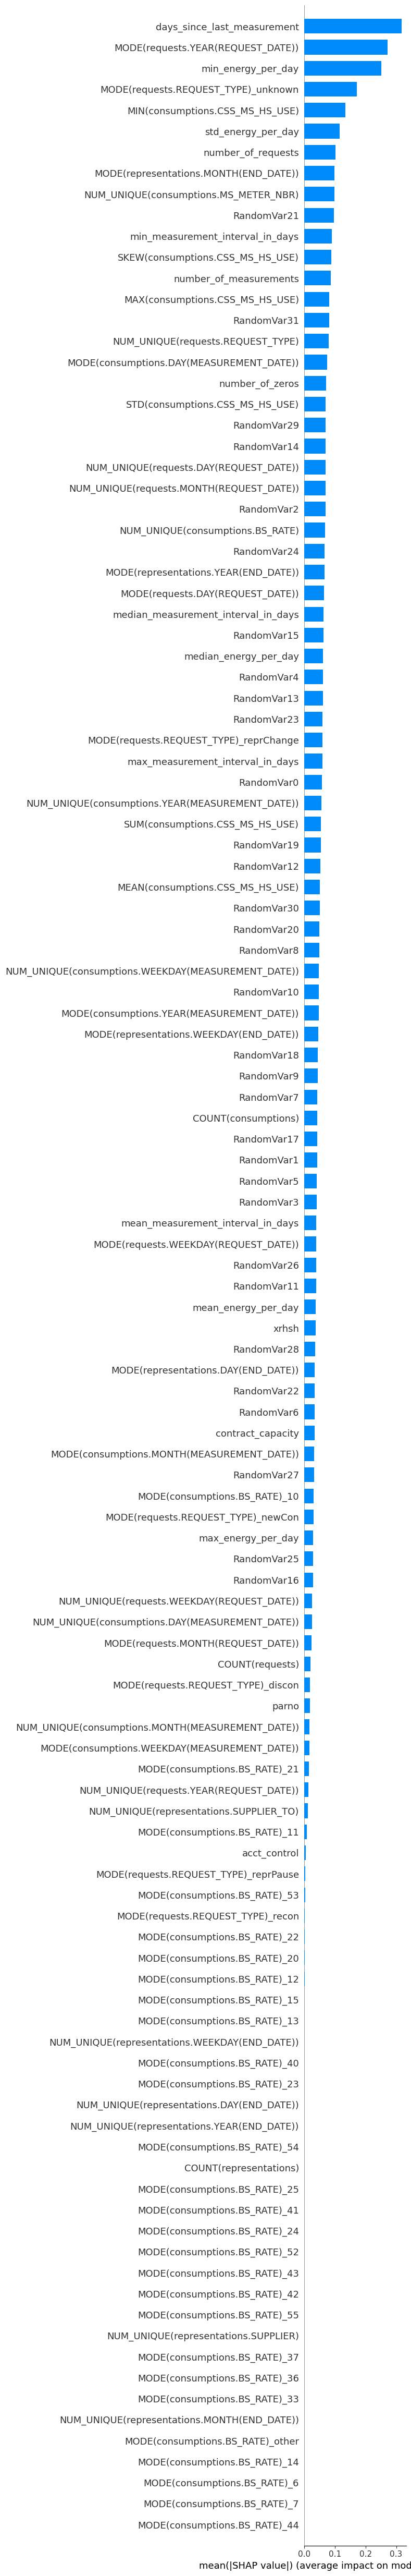

Shape (560415, 120)
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.5161, Demotion: 1.0000, Weighted: 0.6613
0.2 -- Lift: 0.3226, Demotion: 1.0000, Weighted: 0.5258
0.3 -- Lift: 0.2688, Demotion: 1.0000, Weighted: 0.4882
0.4 -- Lift: 0.2339, Demotion: 1.0000, Weighted: 0.4637
0.5 -- Lift: 0.2000, Demotion: 1.0000, Weighted: 0.4400
0.6 -- Lift: 0.1774, Demotion: 1.0000, Weighted: 0.4242
0.7 -- Lift: 0.1659, Demotion: 1.0000, Weighted: 0.4161
0.8 -- Lift: 0.1452, Demotion: 1.0000, Weighted: 0.4016
0.9 -- Lift: 0.1470, Demotion: 1.0000, Weighted: 0.4029
1 -- Lift: 0.1383, Demotion: 1.0000, Weighted: 0.3968
Fold 4 - Accuracy: 0.9978, Precision: 0.8333, Recall: 0.0322, F1: 0.0619, Brier: 0.0021, AUC-ROC: 0.8738, PR-AUC: 0.0886, Lift: 0.2339, Demotion: 1.0000, Weighted: 0.4637


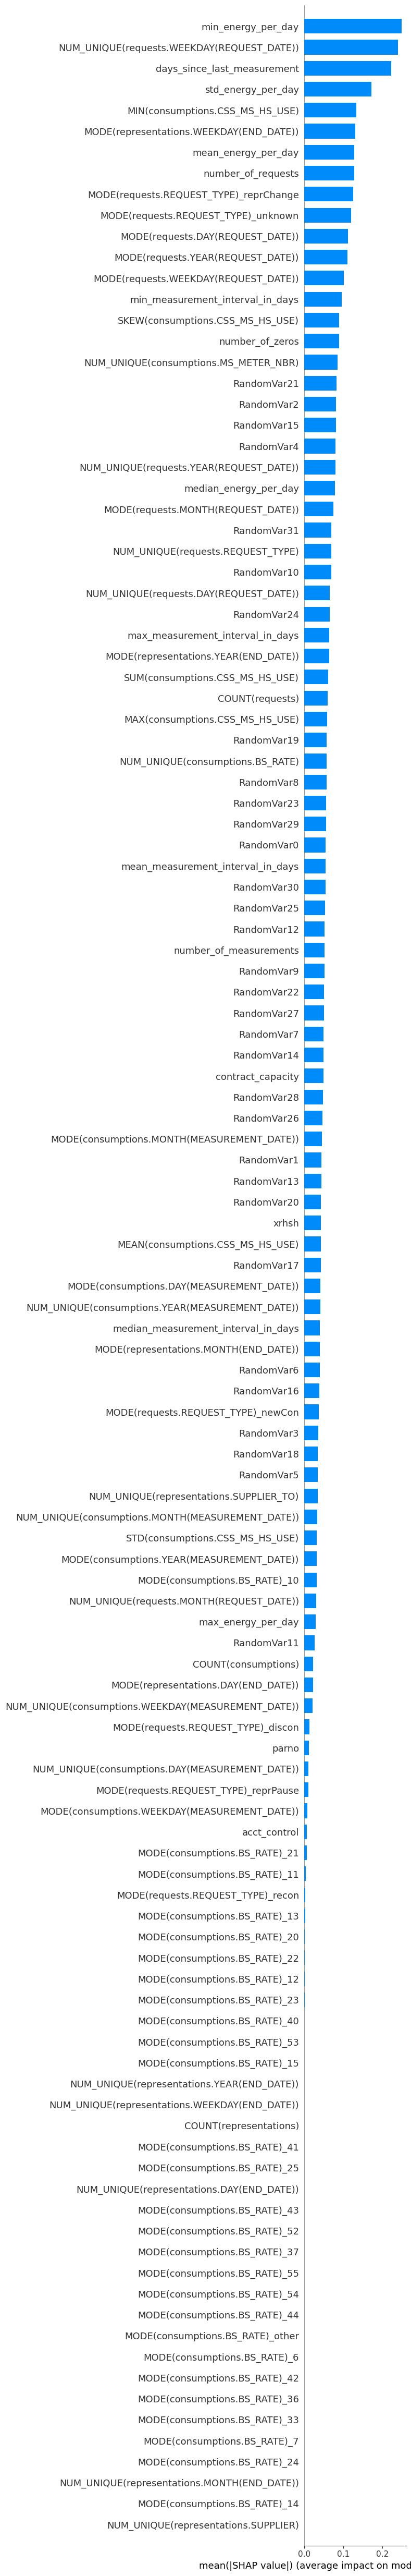

Shape (560416, 120)
bins [559174   1242]
bins [139793    310]
0.1 -- Lift: 0.5484, Demotion: 1.0000, Weighted: 0.6839
0.2 -- Lift: 0.4032, Demotion: 1.0000, Weighted: 0.5823
0.3 -- Lift: 0.3118, Demotion: 1.0000, Weighted: 0.5183
0.4 -- Lift: 0.2581, Demotion: 1.0000, Weighted: 0.4806
0.5 -- Lift: 0.2516, Demotion: 1.0000, Weighted: 0.4761
0.6 -- Lift: 0.2258, Demotion: 1.0000, Weighted: 0.4581
0.7 -- Lift: 0.2074, Demotion: 1.0000, Weighted: 0.4452
0.8 -- Lift: 0.1895, Demotion: 1.0000, Weighted: 0.4327
0.9 -- Lift: 0.1685, Demotion: 1.0000, Weighted: 0.4179
1 -- Lift: 0.1548, Demotion: 1.0000, Weighted: 0.4084
Fold 5 - Accuracy: 0.9979, Precision: 0.8125, Recall: 0.0419, F1: 0.0798, Brier: 0.0021, AUC-ROC: 0.8680, PR-AUC: 0.1057, Lift: 0.2581, Demotion: 1.0000, Weighted: 0.4806


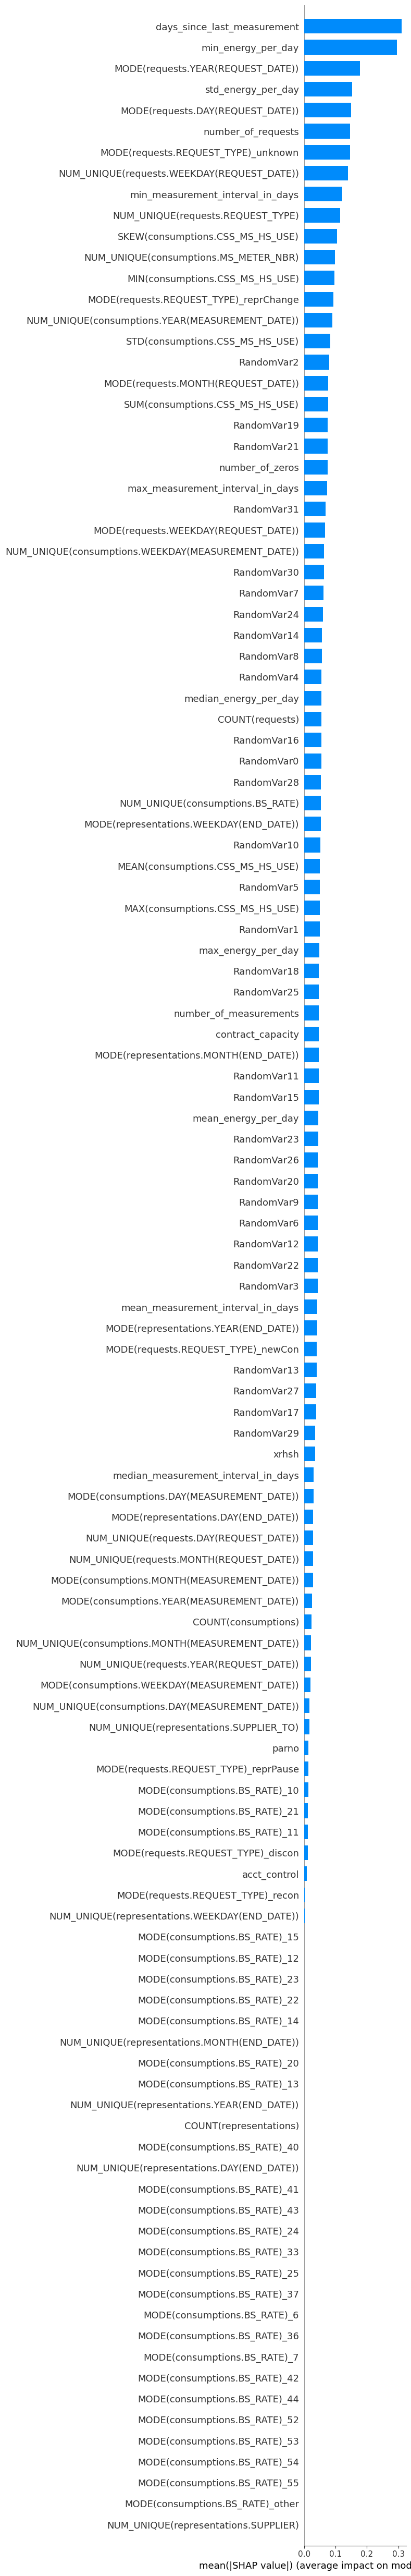

Average - Accuracy: 0.9978, Precision: 0.7670, Recall: 0.0374, F1: 0.0712, Brier: 0.0021, AUC-ROC: 0.8819, PR-AUC: 0.1044, Lift: 0.2565, Demotion: 1.0000, Weighted: 0.4795



In [17]:
clf = CatBoostClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = tmp_df.drop(['target'], axis=1)
y = tmp_df['target']
cols = list(tmp_df.columns)
cols.remove('target')
train(clf, X, y, cols)